# Predicting stock prices using Recurrent Neural Networks (RNN)

Adrian P. Bustamante, Ph.D.

adrianpebus@gmail.com

### __Table of Contents__

<ol>
    <li><a href="#1.Objective">Objective</a></li>
    <li><a href="#2.About-the-data">About the data</a></li>
    <li><a href="#3.Data-Preparation">Data Preparation</a></li>
    <li><a href="#4.RNN-models-with-hyperparameters-tuning">RNN models with hyperparameters tuning</a></li>
    <li><a href="#5.Summary-of-the-results">Summary of the results</a></li>
    <li><a href="#6.Conclusion">Conclusion</a></li>
</ol>

## 1.Objective<a class="anchor" id="Objective"></a>

We consider prices/volume of IBM stocks in a period of around 1000 days, between January 2020 and April 2024. The objective is to use Recurrent Neural Networks (RNN) to predict the stock prices and volume for 90 days (about 10% of the data). We consider a few simple RNN architectures, including LSTM and GRU. We also use keras tuner to optimize hyperparameters (Dropout, units, optimizer, and learning rate). 

## 2.About the data<a class="anchor" id="data"></a>

Description

International Business Machines Corporation, together with its subsidiaries, provides integrated solutions and services worldwide. The company operates through Software, Consulting, Infrastructure, and Financing segments. The Software segment offers a hybrid cloud and AI platforms that allows clients to realize their digital and AI transformations across the applications, data, and environments in which they operate. The Consulting segment focuses on skills integration for strategy, experience, technology, and operations by domain and industry. The Infrastructure segment provides on-premises and cloud based server, and storage solutions, as well as life-cycle services for hybrid cloud infrastructure deployment. The Financing segment offers client and commercial financing, facilitates IBM clients' acquisition of hardware, software, and services. The company has a strategic partnership to various companies including hyperscalers, service providers, global system integrators, and software and hardware vendors that includes Adobe, Amazon Web services, Microsoft, Oracle, Salesforce, Samsung Electronics and SAP, and others. The company was formerly known as Computing-Tabulating-Recording Co. International Business Machines Corporation was incorporated in 1911 and is headquartered in Armonk, New York.

This dataset contains historical stock price data for International Business Machines Corporation (IBM) from [Jan/01/2020] to [May/01/2024]. The dataset includes daily closing prices, adjusted closing prices, and other relevant information.
Features:

    Date, Open, High, Low, Close, Adj Close, Volume.

Source: https://www.kaggle.com/datasets/innocentmfa/ibm-stock-prices-dataset


In [1]:
import kagglehub, pandas as pd

# Download latest version
path = kagglehub.dataset_download("innocentmfa/ibm-stock-prices-dataset")


#print("Path to dataset files:", path)

In [2]:
from os.path import join
df = pd.read_csv(join(path, 'IBM.csv'))
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,129.063095,129.942642,128.843216,129.464630,105.346336,3293436
1,2020-01-03,127.695984,128.929260,127.686424,128.432129,104.506195,2482890
2,2020-01-06,127.552582,128.336517,127.342255,128.202682,104.319489,2537073
3,2020-01-07,127.810707,129.024857,127.533463,128.288712,104.389488,3232977
4,2020-01-08,128.594650,129.885284,128.030594,129.359467,105.260765,4545916
...,...,...,...,...,...,...,...
1084,2024-04-24,183.169998,184.289993,181.399994,184.100006,184.100006,7616600
1085,2024-04-25,168.199997,172.449997,165.660004,168.910004,168.910004,16702200
1086,2024-04-26,167.500000,167.869995,165.729996,167.130005,167.130005,8983800
1087,2024-04-29,167.399994,168.220001,166.229996,167.429993,167.429993,5242200


## 3.Data Preparation

##### Number of days we want to predict

In [3]:
length = 90
####the models/hyperparameters are tuned according the number of days we want to predict

##### importing libraries

In [41]:
import numpy as np, tensorflow as tf, tensorflow.keras as keras
import sklearn 
import keras_tuner as kt
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use('dark_background')

##### Utility methods

In [5]:
##custome sliding window scaler
class window_scaler():
    def __init__(self, window_size=3):
        self.norm_coefs_ = []
        self.window_size_ = window_size
    
    def fit_transform(self, data):
        data= np.array(data)
        '''data has to be a nXm np.array/pd.dataframe'''
        if self.window_size_==0:
            print('Size has to be >=1')
        else:
            chunks = int(len(data)/self.window_size_)
            n_b = int(chunks*self.window_size_)
            n_data = data.shape[0]
        b = np.empty((int(chunks*self.window_size_), np.array(data).shape[1]))
        for i in range(chunks):
            b[n_b-int((i+1)*self.window_size_):n_b-int(i*self.window_size_)] = \
                    data[n_data-int((i+1)*self.window_size_):n_data-int(i*self.window_size_)]/(data[n_data-int((i+1)*self.window_size_)-1]+1e-5)
            self.norm_coefs_.append(data[n_data-int((i+1)*self.window_size_)-1]+1e-5)
        return b

    def inverse_transform(self, b_data):
        '''b_data has to be of shape (chunks*window_size, m)'''
        if len(self.norm_coefs_)==0:
            print("Haven't fit_transform anything yet")
        else:
            coeffs = list(reversed(self.norm_coefs_))
        a =np.empty((b_data.shape))
        for i in range(len(coeffs)):
            a[i*self.window_size_:(i+1)*self.window_size_] = coeffs[i]*b_data[i*self.window_size_:(i+1)*self.window_size_]
        return a

def train_test_plot(data, length=length, title='Data'):
    if data.shape[1]!=2:
        print('data must be a nx2 array')
    elif data.shape[0]< length:
        print('Size of the data must be larget thatn length')
    else:
        target_data = data[-length:]
        train_data = data[:-length]
        target_ticks = np.array(range(train_data.shape[0], len(data)))
        train_ticks = np.array(range(train_data.shape[0]))
        
        fig = plt.figure(figsize=(14, 4))
        fig.suptitle(title)
        
        ax = fig.add_subplot(1,2,1)
        ax.plot(train_ticks, train_data[:,0], label='train_data', color='blue')
        ax.plot(target_ticks, target_data[:,0], label='target_data', color='orange')
        ax.legend()
        ax.set_title('Price (Open)')
        ax.set_xlabel('days')

        ax = fig.add_subplot(1,2,2)
        ax.plot(train_ticks, train_data[:,1], label='train_data', color='blue')
        ax.plot(target_ticks, target_data[:,1], label='target_targe', color='orange')
        ax.legend()
        ax.set_title('Volume')
        ax.set_xlabel('days')


def train_test_sequences(data, seq_length = length):
    ''' data must be a np.array or pd.DataFrame'''
    sequence_X = np.zeros((data.shape[0]-2*seq_length+1, seq_length, data.shape[1]))
    sequence_y = np.zeros((data.shape[0]-2*seq_length+1, seq_length, data.shape[1]))
    for i in range(len(data)-2*seq_length+1):
        sequence_X[i,:,0] = data[i:i+seq_length, 0]
        sequence_X[i,:,1] = data[i:i+seq_length, 1]
        sequence_y[i,:,0] = data[i+seq_length : i+2*seq_length, 0]
        sequence_y[i,:,1] = data[i+seq_length : i+2*seq_length, 1]
    X_train_sequence = sequence_X[:-length] ###the last element is [p_{N-3\ell+1}, ..., p_{N-2\ell}]
    X_test_sequence = sequence_X[-length:]  ## the last element is [p_{N-2\ell+1},...,p_{N-\ell}] 
    y_train_sequence = sequence_y[:-length] ##the last element is [p_{N-2\ell +1},...,p_{N-\ell}]  Does not include targets
    y_test_sequence = sequence_y[-length:] ## the first element is [p_{N-2\ell+2},...,p_{N-\ell +1}] It includes target data
    return X_train_sequence, y_train_sequence, X_test_sequence, y_test_sequence

def simple_model_plot(y_pred, data, length=length, title='Simple Model'):
    target_data = data[-length:]
    train_data = data[:-length]
    target_ticks = np.array(range(train_data.shape[0], len(data)))
    train_ticks = np.array(range(train_data.shape[0]))

    fig = plt.figure(figsize=(14, 4))
    fig.suptitle(title)
    
    ax = fig.add_subplot(1,2,1)
    ax.plot(train_ticks, train_data[:,0], label='Train data', color='blue')
    ax.plot(target_ticks, target_data[:,0], label='Target data', color='orange')
    ax.plot(target_ticks, y_pred[-1,:,0], label='Predicted', color='green')
    ax.legend()
    ax.set_title('Price (Open)')
    ax.set_xlabel('days')

    ax = fig.add_subplot(1,2,2)
    ax.plot(train_ticks, train_data[:,1], label='Train data', color='blue')
    ax.plot(target_ticks, target_data[:,1], label='Target data', color='orange')
    ax.plot(target_ticks, y_pred[-1,:,1], label='Predicted', color='green')
    ax.legend()
    ax.set_title('Volume')
    ax.set_xlabel('days')

def model_results(y_pred, history, data, length=length, model_name='Model', scaler=window_scaler()):
    target_data = data[-length:]
    train_data = data[:-length]
    target_ticks = np.array(range(train_data.shape[0], len(data)))
    train_ticks = np.array(range(train_data.shape[0]))
    original_data_scaled=np.concatenate([train_data, target_data])
    predicted_data_scaled = np.concatenate([train_data, y_pred[-1]])
    original_data = scaler.inverse_transform(original_data_scaled)
    predicted_data = scaler.inverse_transform(predicted_data_scaled)

    fig = plt.figure(figsize=(14, 4))
    fig.suptitle(model_name)
    
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(target_ticks, target_data[:,0],color='orange', label='Target data')
    ax.plot(target_ticks, y_pred[-1,:,0],color='green', label='Predicted')
    ax.legend()
    ax.set_title('Price (Open)')
    ax.set_xlabel('days')

    ax = fig.add_subplot(1,2,2)
    ax.plot(target_ticks, target_data[:,1], color='orange', label=' Target data')
    ax.plot(target_ticks, y_pred[-1,:,1], color='green' ,label='Predicted')
    ax.legend()
    ax.set_title('Volume')
    ax.set_xlabel('days')


    fig = plt.figure(figsize=(14, 4))
    fig.suptitle(model_name)
    
    ax = fig.add_subplot(1,2,1)
    ax.plot(train_ticks, train_data[:,0], color='blue', label='Train data')
    ax.plot(target_ticks, target_data[:,0], color='orange',label='Target data')
    ax.plot(target_ticks, y_pred[-1,:,0], color='green',label='Predicted')
    ax.legend()
    ax.set_title('Price (Open)')
    ax.set_xlabel('days')

    ax = fig.add_subplot(1,2,2)
    ax.plot(train_ticks, train_data[:,1], color='blue', label='Train data') 
    ax.plot(target_ticks, target_data[:,1], color='orange', label='Target data')
    ax.plot(target_ticks, y_pred[-1,:,1], color='green', label='Predicted')
    ax.legend()
    ax.set_title('Volume')
    ax.set_xlabel('days')

    fig = plt.figure(figsize=(14, 4))

    n = len(history.history["loss"])
    ax = fig.add_subplot(1,1,1)
    ax.plot(range(n), (history.history["loss"]), color= 'red', label="Train Loss")
    ax.plot(range(n), (history.history["val_loss"]), color='yellow', label="Validation Loss")
    ax.set_xlabel('epochs')
    ax.legend()
    ax.set_title('Mean Squared Error. ' + model_name)

    fig = plt.figure(figsize=(14, 4))
    fig.suptitle(model_name+  str( '. Original scale'))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(target_ticks, original_data[-length:,0], color='orange',label='Target data')
    ax.plot(target_ticks, predicted_data[-length:,0],color='green', label='Predicted')
    ax.legend()
    ax.set_title('Price (Open)')
    ax.set_xlabel('days')

    ax = fig.add_subplot(1,2,2)
    ax.plot(target_ticks, original_data[-length:,1], color='orange', label='Target data')
    ax.plot(target_ticks, predicted_data[-length:,1], color='green', label='Predicted')
    ax.legend()
    ax.set_title('Volume')
    ax.set_xlabel('days')
    
    fig = plt.figure(figsize=(14, 4))
    fig.suptitle(model_name +  str( '. Original scale'))
    
    ax = fig.add_subplot(1, 2, 1)

    ax.plot(train_ticks, original_data[:-length,0], color='blue',label='Train data')
    ax.plot(target_ticks, original_data[-length:,0], color='orange',label='Target data')
    ax.plot(target_ticks, predicted_data[-length:,0], color='green',label='Predicted')
    ax.legend()
    ax.set_title('Price (Open)')
    ax.set_xlabel('days')

    ax = fig.add_subplot(1,2,2)
    ax.plot(train_ticks, original_data[:-length,1], color='blue',label='Train data')
    ax.plot(target_ticks, original_data[-length:,1], color='orange', label='Target data')
    ax.plot(target_ticks, predicted_data[-length:,1], color='green',label='Predicted')
    ax.legend()
    ax.set_title('Volume')
    ax.set_xlabel('days')

def model_error_params(y_pred, model, hp, models_dic,length=length):
    models_dic.update({model.name: sklearn.metrics.mean_squared_error(y_test[-1], y_pred[-1])})
    print(f'MSE for the last {length} days predicted: ', models_dic[model.name]) 
    print(f'Best hyperparameters found for model {model.name}: {hp.values}')


##### Target features

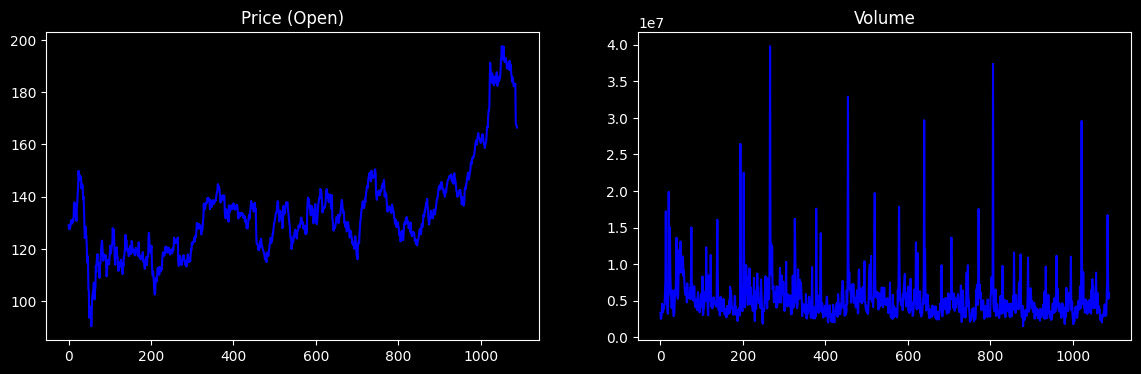

In [6]:
## we will keep only the open price and volume
data = df[['Open', 'Volume']].copy()
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(data['Open'], color = 'blue')
ax.set_title('Price (Open)')
ax = fig.add_subplot(1,2,2)
ax.plot(data['Volume'], color='blue')
ax.set_title('Volume')
plt.show()

#### Problems with MinMax Scaler

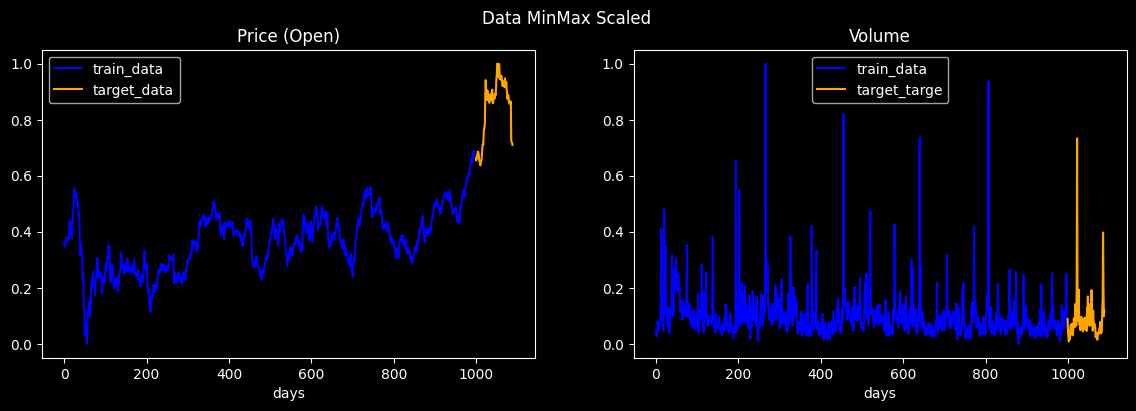

In [7]:
scaler_mm = sklearn.preprocessing.MinMaxScaler()
scaled_data_mm= scaler_mm.fit_transform(data)

train_test_plot(scaled_data_mm, title='Data MinMax Scaled')

As we can see in the figure above, the Open Price of the stocks has an increasing trend. This implies that most of the values in the target set are out of the scale of the train set, which brings about the problem that the Recurrent Networks we will implement need to predict some numbers that have not been seen before. We can see this by training a simple RNN:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


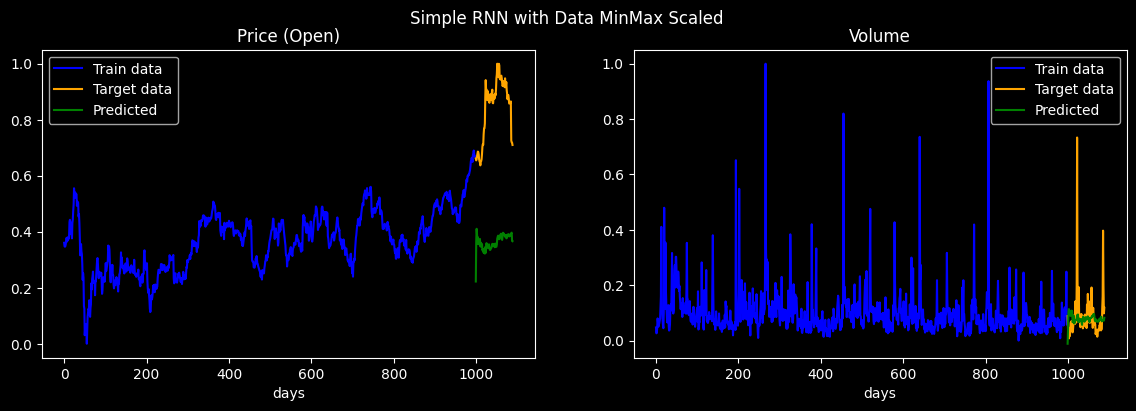

In [42]:
X_train, y_train, X_test, y_test= train_test_sequences(scaled_data_mm)

simple_model= keras.models.Sequential(name= 'Simple_model')
simple_model.add(keras.layers.Input( shape=(length,2) ) )
simple_model.add(keras.layers.SimpleRNN(units=150, return_sequences=True))#, #return_sequences=True))
simple_model.add(keras.layers.Dense(units=2))

simple_model.compile(optimizer='adam', loss='mse')
simple_model.fit(X_train, y_train, epochs=10, verbose=0)

yhat = simple_model.predict(X_test)
simple_model_plot(yhat, scaled_data_mm, title='Simple RNN with Data MinMax Scaled')

We can see in the figure above that the predicted values are outside the range of the target set (and within the range of the training set).

To solve this issue, we normalize the data in windows of size $\ell$ as follows
$$\begin{align*}
 &\vdots \\
W_t &= \left(\frac{p_{t\ell}}{p_{t\ell -1}}, \frac{p_{t\ell+1}}{p_{t\ell -1}}, \dots, \frac{p_{(t+1)\ell-1}}{p_{t\ell -1}}\right)   \\
W_{t+1} &= \left(\frac{p_{(t+1)\ell}}{p_{(t+1)\ell -1}}, \frac{p_{(t+1)\ell+1}}{p_{(t+1)\ell -1}}, \dots, \frac{p_{(2t+1)\ell-1}}{p_{(t+1)\ell -1}}\right) \\
  & \vdots
\end{align*}
$$
In this way the normalizing factors always belong to the train set, see below (Writing the data as sequences). 

Note that we use a very simple normalization technique. See, for example https://www.sciencedirect.com/science/article/abs/pii/S030643792400173X  , for more sophisticated normalization techniques.

### Custom (Sliding window) Normalization

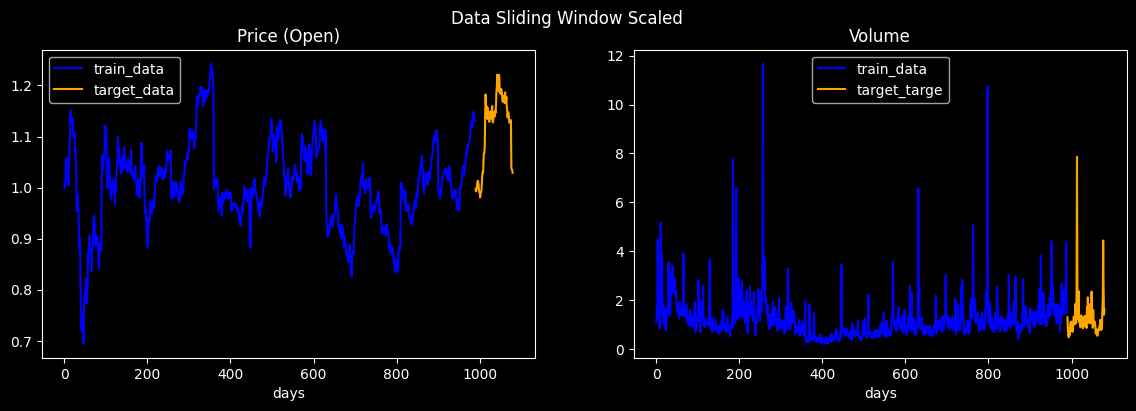

In [9]:
scaler = window_scaler(window_size=length)
scaled_data = scaler.fit_transform(data)
train_test_plot(scaled_data, title='Data Sliding Window Scaled')

We can see above that, scaling the data using sliding windows, now the target set is within the range of the train set. Let's check how the simple model performs:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


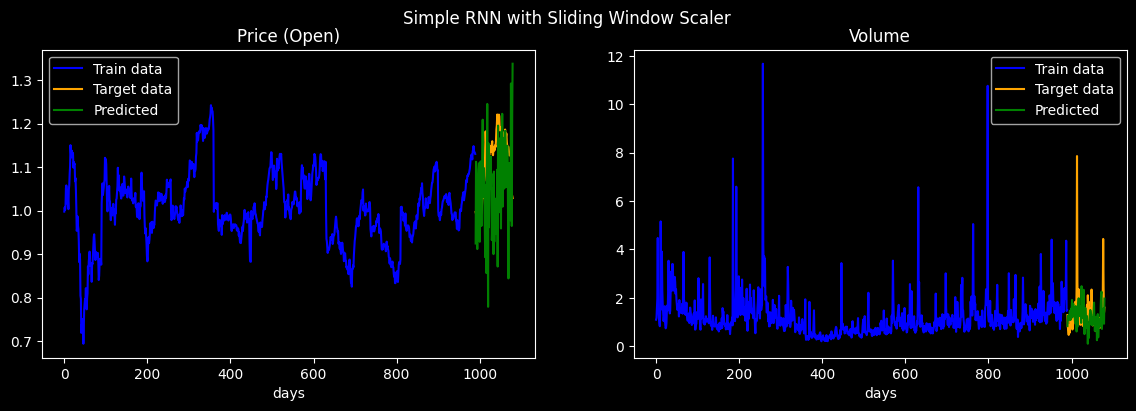

In [43]:
X_train, y_train, X_test, y_test = train_test_sequences(data=scaled_data)

simple_model.fit(X_train, y_train, epochs=10, verbose=0)
yhat = simple_model.predict(X_test)

simple_model_plot(yhat, scaled_data, title='Simple RNN with Sliding Window Scaler')

We can see above that with the sliding window normalization the predicted data is in the range of the target set. Now that we have a helpful normalization in the next section we are going to build and tune different models.

### Writing the data as sequences

Stock prices/volumes are time series of length $N$, i.e., $p_0, p_1, p_2,..., p_N$, where $p_i=$(price, volume) on the day $i$, $0\leq i\leq N$.   RNN are mainly used to deal with sequential data. The models that we are about to construct use values in sequential form, i.e., we construct sequences of the form 
$$\begin{align*}
X_0&=[p_0,p_1,...,p_{\ell-1}], & &y_0=[p_\ell, p_{\ell+1}, ..., p_{2\ell-1}] \\
X_1&=[p_1,p_2,...,p_{\ell}], & &y_1=[p_{\ell+1}, p_{\ell+2}, ..., p_{2\ell}]\\
X_2&=[p_2,p_2,...,p_{\ell+1}], & &y_2=[p_{\ell+2}, p_{\ell+3}, ..., p_{2\ell+1}]\\
 &\vdots & & \vdots    \\
X_{N-2\ell+1}&=[p_{N-2\ell+1},p_{N-2\ell+2},...,p_{N-\ell}], & & y_{N-2\ell+1}=[p_{N-\ell+1}, p_{\ell+2},..., p_{N}]\\
\end{align*}$$

where $X_i$ are the inputs to the network, $y_i$ are the respective targets, and $\ell$ is the number of days that we want to predict. With this notation, our objective is to use RNNs to predict prices/volume of the last $\ell( ={length} )$ days, that is, we want to predict $y_{N-2\ell+1}=[p_{N-\ell+1}, p_{\ell+2},..., p_{N}]$.

Note that the train set will be of the form $\{(X_i, y_i)\}_{i=0}^m$ with $m\leq N-3\ell$. In this way, none of the values on the training set include any of the values we want to predict, i.e., $\{p_{N-\ell+1}, ..., p_N\}$.

In [11]:
X_train, y_train, X_test, y_test= train_test_sequences(scaled_data)

print(f'N={len(scaled_data)}', f'\\ell={length}')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

N=1080 \ell=90
(811, 90, 2) (811, 90, 2) (90, 90, 2) (90, 90, 2)


## 4.RNN models with hyperparameters tuning 

In [12]:
### early stop callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mse_models = {}

#### Simple RNN

In [13]:
##building the model
def build_rnn(hp):
    model = keras.models.Sequential(name = 'RNN')
    model.add(keras.layers.Input(shape=(length, 2)))
    model.add(keras.layers.SimpleRNN(units=hp.Choice('units', [50, 75, 100, 125, 150]), return_sequences=True))
    model.add(keras.layers.Dropout(rate=hp.Choice('rate',[0.0, 0.1, 0.2, 0.3])))
    model.add(keras.layers.Dense(units=2))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1] )
    optimizers_dict = {
        'RMSprop': keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
        'Adam': keras.optimizers.Adam(learning_rate=hp_learning_rate)
    }
    hp_optimizers = hp.Choice('optimizer', values=['RMSprop', 'Adam'])
    model.compile(optimizer=optimizers_dict[hp_optimizers], loss='mse')
    return model

#build_rnn(kt.HyperParameters())

#building the tuner
tuner_rnn = kt.RandomSearch(
    build_rnn,
    objective='val_loss',
    max_trials = 50, 
    max_retries_per_trial=3,
    max_consecutive_failed_trials=5,
    overwrite=True,
    project_name='ibm-stock-rnn')

tuner_rnn.search_space_summary()

Search space summary
Default search space size: 4
units (Choice)
{'default': 50, 'conditions': [], 'values': [50, 75, 100, 125, 150], 'ordered': True}
rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}
optimizer (Choice)
{'default': 'RMSprop', 'conditions': [], 'values': ['RMSprop', 'Adam'], 'ordered': False}


In [14]:
#random search
tuner_rnn.search(X_train[:-length], y_train[:-length], 
                 validation_data =(X_train[-length:], y_train[-length:]),
                 epochs=50,
                 callbacks=[early_stop])
tuner_rnn.results_summary(num_trials=2)

Trial 50 Complete [00h 00m 10s]
val_loss: 0.16368228197097778

Best val_loss So Far: 0.153033047914505
Total elapsed time: 00h 06m 53s
Results summary
Results in ./ibm-stock-rnn
Showing 2 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
units: 150
rate: 0.1
learning_rate: 0.001
optimizer: Adam
Score: 0.153033047914505

Trial 35 summary
Hyperparameters:
units: 50
rate: 0.1
learning_rate: 0.001
optimizer: Adam
Score: 0.1538996547460556


In [15]:
## training the best model found
best_hps_rnn=tuner_rnn.get_best_hyperparameters(num_trials=1)[0]
best_rnn = build_rnn(best_hps_rnn)
best_rnn.summary()

history_rnn = best_rnn.fit(X_train[:-1], y_train[:-1], 
                           validation_data =(X_train[-1:], y_train[-1:]),
                           epochs=50,
                           callbacks=[early_stop])
yhat_rnn = best_rnn.predict(X_test)

Model: "RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 90, 150)        │        22,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90, 2)          │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,252 (90.83 KB)

 Trainable params: 23,252 (90.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6411 - val_loss: 0.3816
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4251 - val_loss: 0.3702
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4153 - val_loss: 0.3275
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3809 - val_loss: 0.2366
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3665 - val_loss: 0.2528
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3637 - val_loss: 0.2253
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3585 - val_loss: 0.2830
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3784 - val_loss: 0.2939
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3452 - val_loss: 0.2603
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3208 - val_loss: 0.3090
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3009 - val_loss: 0.2682
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2

MSE for the last 90 days predicted:  0.48706730522266944
Best hyperparameters found for model RNN: {'units': 150, 'rate': 0.1, 'learning_rate': 0.001, 'optimizer': 'Adam'}


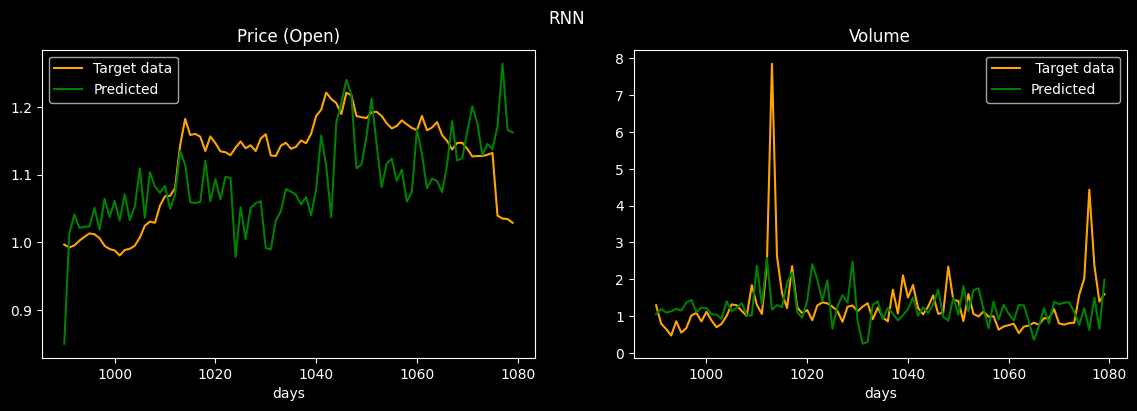

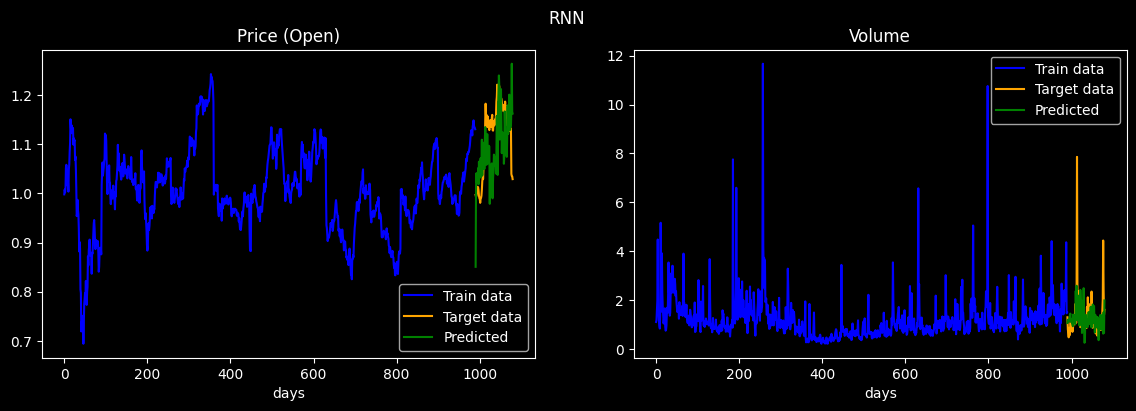

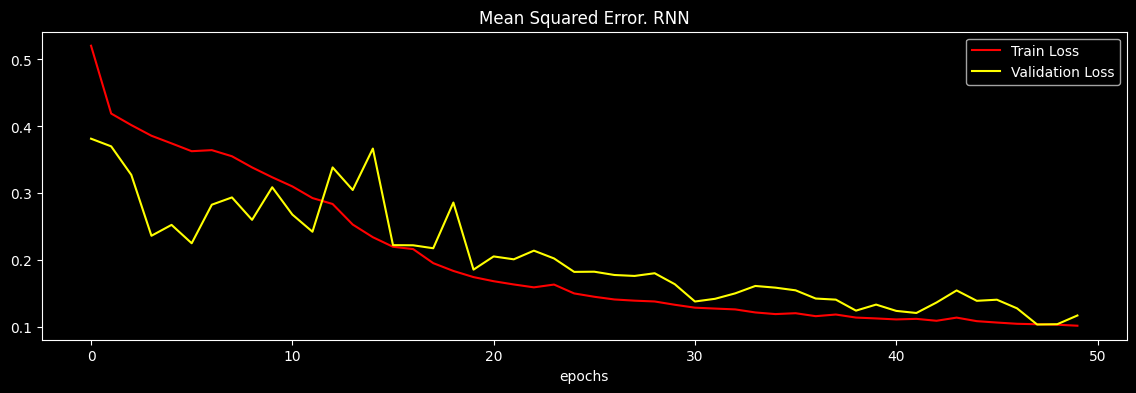

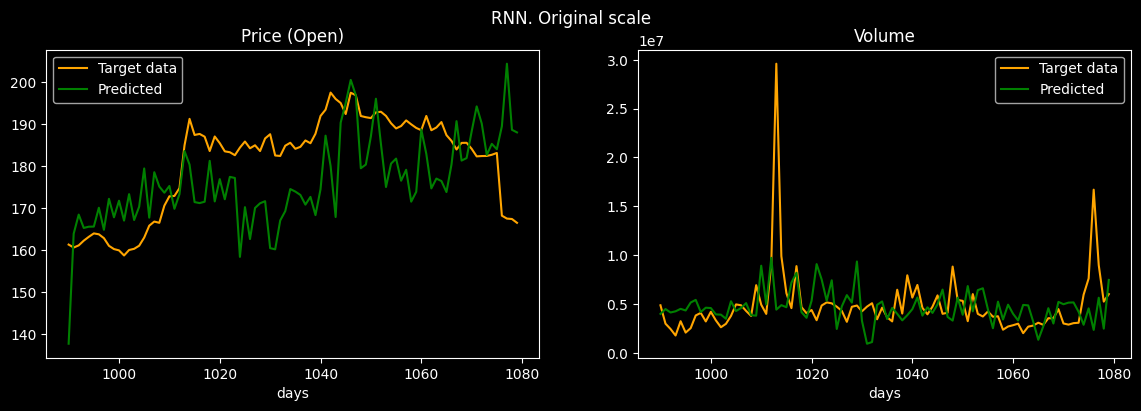

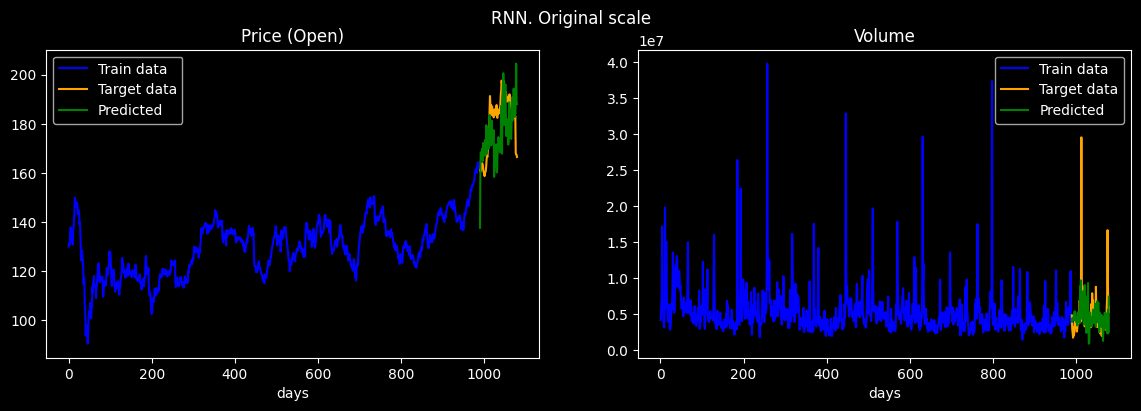

In [16]:
model_results(yhat_rnn, history_rnn, data=scaled_data, model_name=best_rnn.name, scaler=scaler)
model_error_params(yhat_rnn, best_rnn, best_hps_rnn, mse_models,length=length)

#### Deep RNN (two hidden layers)

In [17]:
def build_deep_rnn(hp):
    model = keras.models.Sequential(name = 'Deep_RNN')
    model.add(keras.layers.Input(shape=(length, 2)))
    model.add(keras.layers.SimpleRNN(units=hp.Choice('units_1', [50, 75, 100, 125, 150]), return_sequences=True))
    model.add(keras.layers.SimpleRNN(units=hp.Choice('units_2', [50, 75, 100, 125, 150]), return_sequences=True))
    model.add(keras.layers.Dropout(rate=hp.Choice('rate',[0.0, 0.1, 0.2, 0.3])))
    model.add(keras.layers.Dense(units=2))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1] )
    optimizers_dict = {
        'RMSprop': keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
        'Adam': keras.optimizers.Adam(learning_rate=hp_learning_rate)
    }
    hp_optimizers = hp.Choice('optimizer', values=['RMSprop', 'Adam'])
    model.compile(optimizer=optimizers_dict[hp_optimizers], loss='mse')
    return model

#build_deep_rnn(kt.HyperParameters())

tuner_deep_rnn = kt.RandomSearch(
    build_deep_rnn,
    objective='val_loss',
    max_trials = 50, 
    max_retries_per_trial=3,
    max_consecutive_failed_trials=5,
    overwrite=True,
    project_name='ibm-stock-deep_rnn')

tuner_deep_rnn.search_space_summary()

Search space summary
Default search space size: 5
units_1 (Choice)
{'default': 50, 'conditions': [], 'values': [50, 75, 100, 125, 150], 'ordered': True}
units_2 (Choice)
{'default': 50, 'conditions': [], 'values': [50, 75, 100, 125, 150], 'ordered': True}
rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}
optimizer (Choice)
{'default': 'RMSprop', 'conditions': [], 'values': ['RMSprop', 'Adam'], 'ordered': False}


In [18]:
tuner_deep_rnn.search(X_train[:-length], y_train[:-length], 
                      validation_data =(X_train[-length:], y_train[-length:]), 
                      epochs=50,
                      callbacks=[early_stop])
tuner_deep_rnn.results_summary(num_trials=2)

Trial 50 Complete [00h 00m 14s]
val_loss: 0.21294602751731873

Best val_loss So Far: 0.14826536178588867
Total elapsed time: 00h 11m 06s
Results summary
Results in ./ibm-stock-deep_rnn
Showing 2 best trials
Objective(name="val_loss", direction="min")

Trial 48 summary
Hyperparameters:
units_1: 50
units_2: 100
rate: 0.0
learning_rate: 0.01
optimizer: Adam
Score: 0.14826536178588867

Trial 13 summary
Hyperparameters:
units_1: 75
units_2: 100
rate: 0.0
learning_rate: 0.01
optimizer: Adam
Score: 0.15408918261528015


In [19]:
best_hps_deep_rnn=tuner_deep_rnn.get_best_hyperparameters(num_trials=1)[0]
best_deep_rnn = build_deep_rnn(best_hps_deep_rnn)
best_deep_rnn.summary()

history_deep_rnn = best_deep_rnn.fit(X_train[:-1], y_train[:-1], 
                                     validation_data =(X_train[-1:], y_train[-1:]), 
                                     epochs=50,  
                                     callbacks=[early_stop])
yhat_deep_rnn = best_deep_rnn.predict(X_test)

Model: "Deep_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 90, 50)         │         2,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 90, 100)        │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90, 2)          │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,952 (70.12 KB)

 Trainable params: 17,952 (70.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.5398 - val_loss: 0.2906
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3738 - val_loss: 0.3619
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3795 - val_loss: 0.3398
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3882 - val_loss: 0.3078
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3798 - val_loss: 0.2966
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3650 - val_loss: 0.2949
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3607 - val_loss: 0.3268
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3657 - val_loss: 0.2748
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3886 - val_loss: 0.4318
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3766 - val_loss: 0.2906
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3560 - val_loss: 0.3160
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3

MSE for the last 90 days predicted:  0.4382475622385437
Best hyperparameters found for model Deep_RNN: {'units_1': 50, 'units_2': 100, 'rate': 0.0, 'learning_rate': 0.01, 'optimizer': 'Adam'}


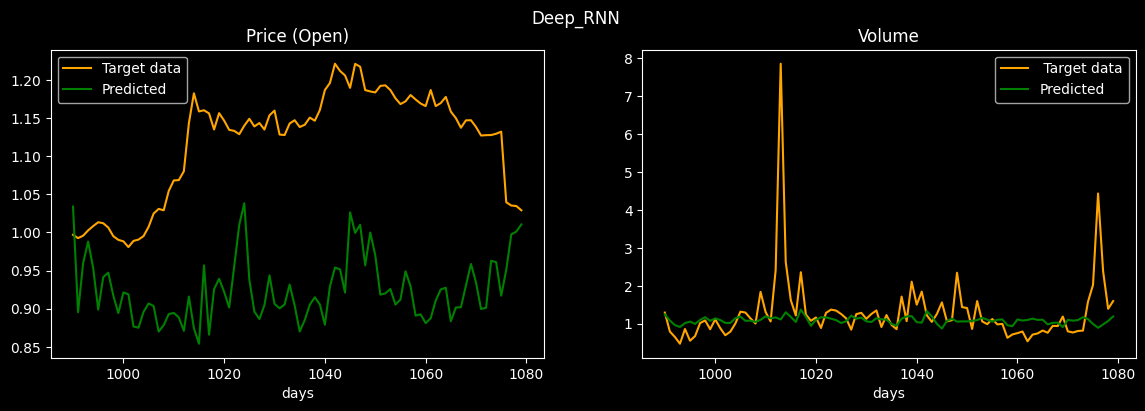

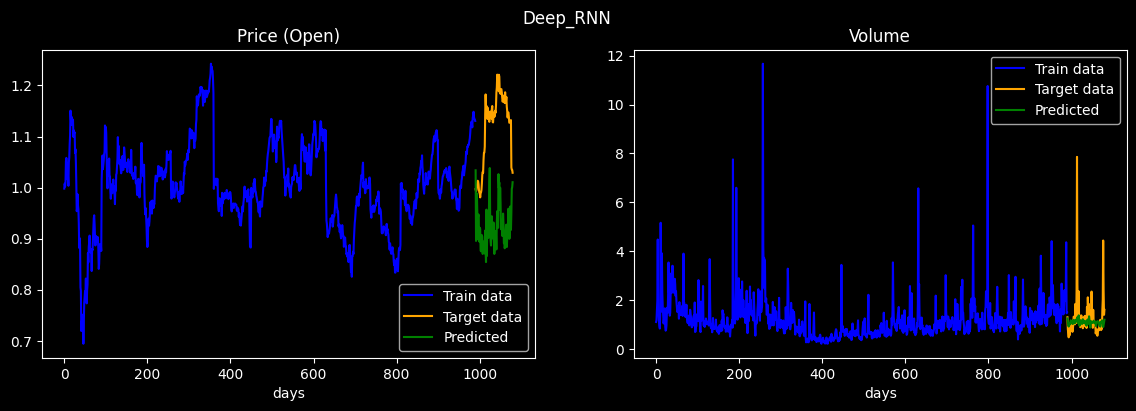

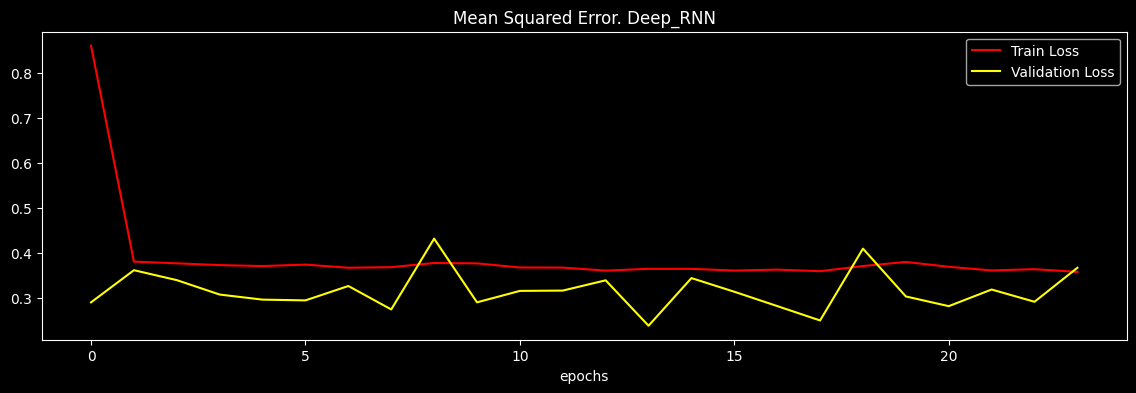

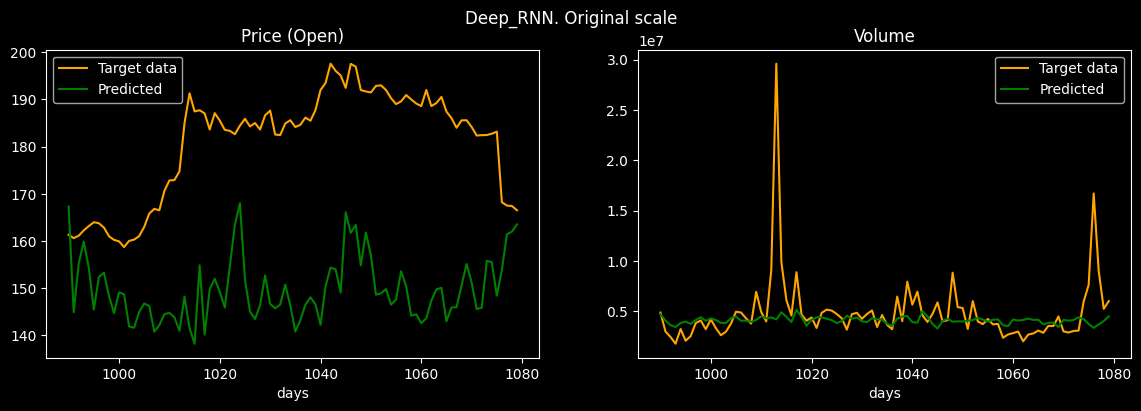

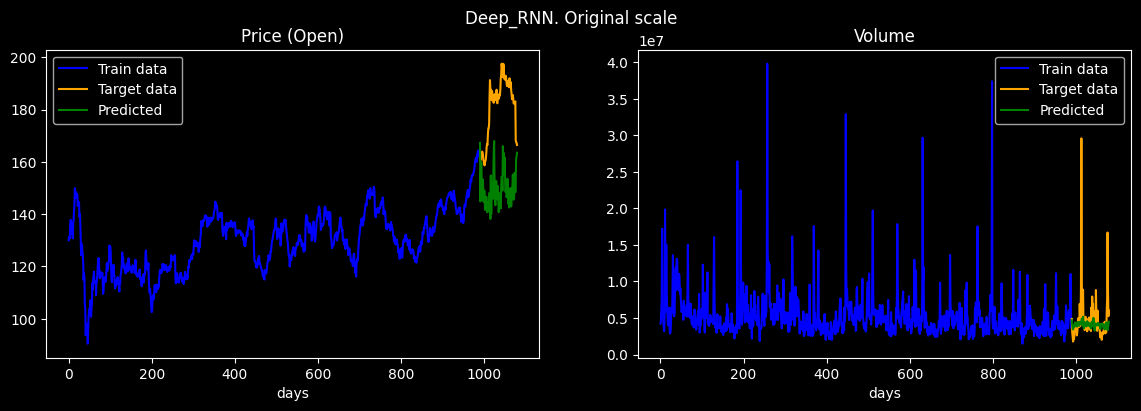

In [20]:
model_results(yhat_deep_rnn, history_deep_rnn, data=scaled_data, model_name=best_deep_rnn.name, scaler=scaler)
model_error_params(yhat_deep_rnn, best_deep_rnn, best_hps_deep_rnn, mse_models,length=length)

#### LSTM (Long short-term memory)

In [21]:
def build_lstm(hp):
    model = keras.models.Sequential(name = 'LSTM')
    model.add(keras.layers.Input(shape=(length, 2)))
    model.add(keras.layers.LSTM(units=hp.Choice('units', [50, 75, 100, 125, 150]), return_sequences=True))
    model.add(keras.layers.Dropout(rate=hp.Choice('rate',[0.0, 0.1, 0.2, 0.3])))
    model.add(keras.layers.Dense(units=2))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1] )
    optimizers_dict = {
        'RMSprop': keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
        'Adam': keras.optimizers.Adam(learning_rate=hp_learning_rate)
    }
    hp_optimizers = hp.Choice('optimizer', values=['RMSprop', 'Adam'])
    model.compile(optimizer=optimizers_dict[hp_optimizers], loss='mse')
    return model

#build_lstm(kt.HyperParameters())

tuner_lstm = kt.RandomSearch(
    build_lstm,
    objective='val_loss',
    max_trials = 50, 
    max_retries_per_trial=3,
    max_consecutive_failed_trials=5,
    overwrite=True,
    project_name='ibm-stock-lstm')

tuner_lstm.search_space_summary()

Search space summary
Default search space size: 4
units (Choice)
{'default': 50, 'conditions': [], 'values': [50, 75, 100, 125, 150], 'ordered': True}
rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}
optimizer (Choice)
{'default': 'RMSprop', 'conditions': [], 'values': ['RMSprop', 'Adam'], 'ordered': False}


In [22]:
tuner_lstm.search(X_train[:-length], y_train[:-length], 
                  validation_data =(X_train[-length:], y_train[-length:]), 
                  epochs=50,
                  callbacks=[early_stop])
tuner_lstm.results_summary(num_trials=2)

Trial 50 Complete [00h 00m 08s]
val_loss: 0.16256815195083618

Best val_loss So Far: 0.13639023900032043
Total elapsed time: 00h 19m 57s
Results summary
Results in ./ibm-stock-lstm
Showing 2 best trials
Objective(name="val_loss", direction="min")

Trial 27 summary
Hyperparameters:
units: 100
rate: 0.2
learning_rate: 0.001
optimizer: RMSprop
Score: 0.13639023900032043

Trial 46 summary
Hyperparameters:
units: 125
rate: 0.0
learning_rate: 0.001
optimizer: RMSprop
Score: 0.13650022447109222


In [23]:
best_hps_lstm=tuner_lstm.get_best_hyperparameters(num_trials=1)[0]
best_lstm = build_lstm(best_hps_lstm)
best_lstm.summary()

history_lstm = best_lstm.fit(X_train[:-1], y_train[:-1], 
                             validation_data =(X_train[-1:], y_train[-1:]), 
                             epochs=50, 
                             callbacks=[early_stop])
yhat_lstm = best_lstm.predict(X_test)

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 90, 100)        │        41,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90, 2)          │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,402 (161.73 KB)

 Trainable params: 41,402 (161.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.8944 - val_loss: 0.4769
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.4234 - val_loss: 0.4192
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4233 - val_loss: 0.3447
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.3946 - val_loss: 0.2870
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.3918 - val_loss: 0.2681
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3963 - val_loss: 0.2633
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3746 - val_loss: 0.3253
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4076 - val_loss: 0.3208
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.3919 - val_loss: 0.2548
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.3821 - val_loss: 0.2587
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.3887 - val_loss: 0.3724
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.3

MSE for the last 90 days predicted:  0.43394485339770544
Best hyperparameters found for model LSTM: {'units': 100, 'rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}


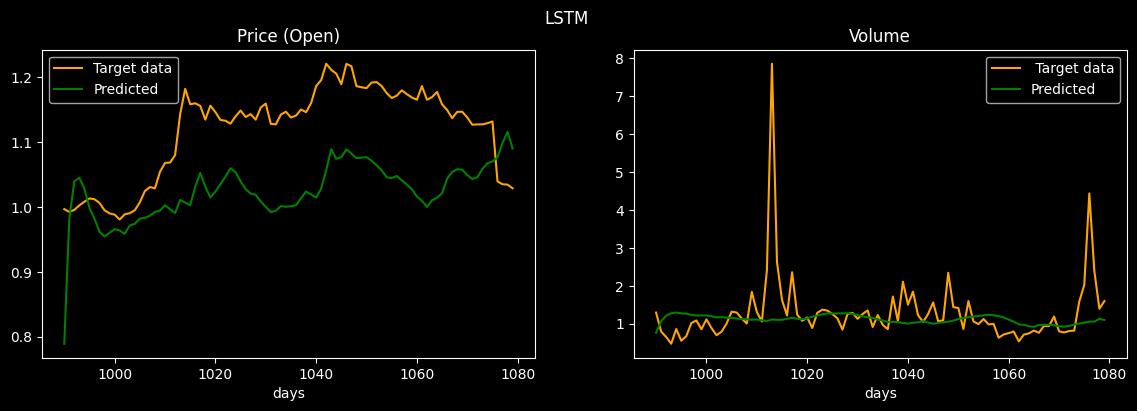

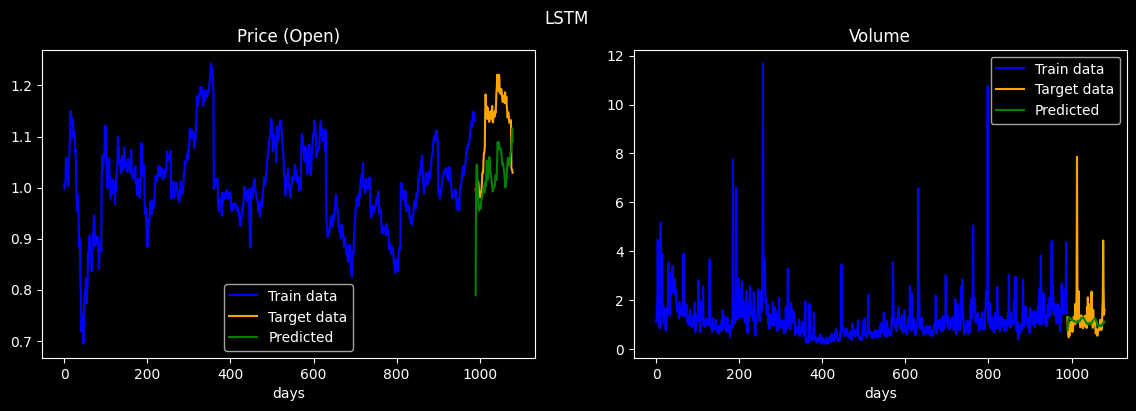

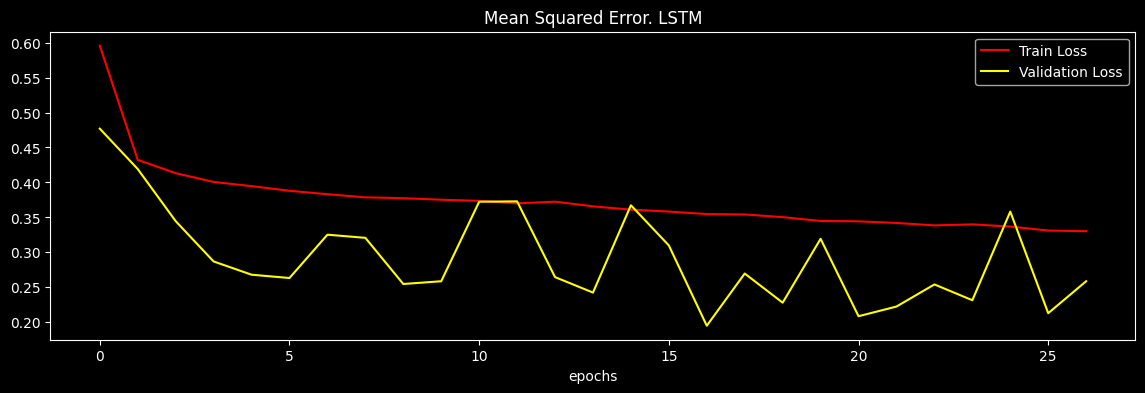

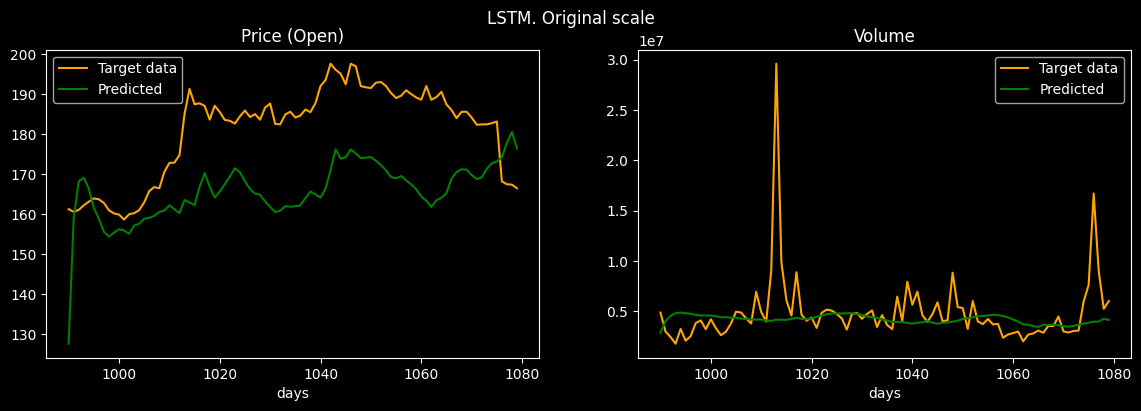

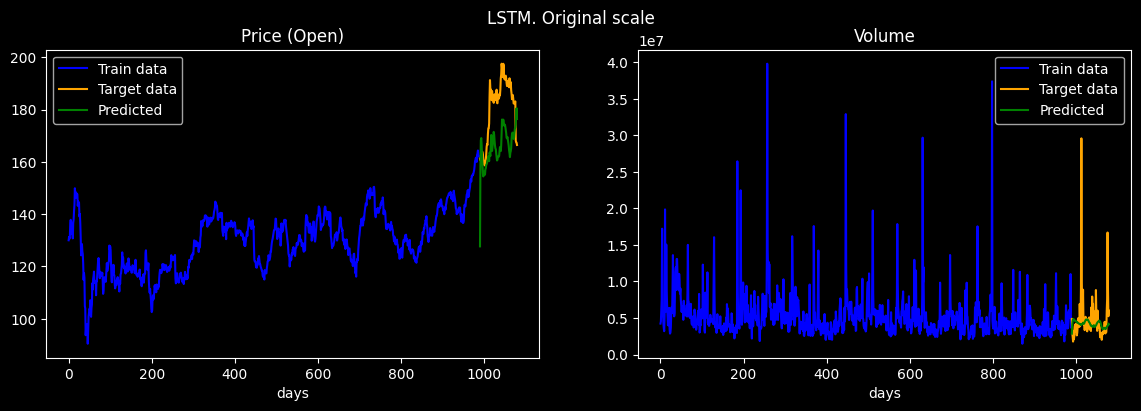

In [24]:
model_results(yhat_lstm, history_lstm, data=scaled_data, model_name=best_lstm.name, scaler=scaler)
model_error_params(yhat_lstm, best_lstm, best_hps_lstm, mse_models,length=length)

#### Deep LSTM (two hidden layers)

In [25]:
def build_deep_lstm(hp):
    model = keras.models.Sequential(name = 'Deep_LSTM')
    model.add(keras.layers.Input(shape=(length, 2)))
    model.add(keras.layers.LSTM(units=hp.Choice('units_1', [50, 75, 100, 125, 150]), return_sequences=True))
    #model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LSTM(units=hp.Choice('units_2', [50, 75, 100, 125, 150]), return_sequences=True))
    model.add(keras.layers.Dropout(rate=hp.Choice('rate',[0.0, 0.1, 0.2, 0.3])))
    model.add(keras.layers.Dense(units=2))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1] )
    optimizers_dict = {
        'RMSprop': keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
        'Adam': keras.optimizers.Adam(learning_rate=hp_learning_rate)
    }
    hp_optimizers = hp.Choice('optimizer', values=['RMSprop', 'Adam'])
    model.compile(optimizer=optimizers_dict[hp_optimizers], loss='mse')
    return model

#build_deep_lstm(kt.HyperParameters())

tuner_deep_lstm = kt.RandomSearch(
    build_deep_lstm,
    objective='val_loss',
    max_trials = 50, 
    max_retries_per_trial=3,
    max_consecutive_failed_trials=5,
    overwrite=True,
    project_name='ibm-stock-deep_lstm')

tuner_deep_lstm.search_space_summary()

Search space summary
Default search space size: 5
units_1 (Choice)
{'default': 50, 'conditions': [], 'values': [50, 75, 100, 125, 150], 'ordered': True}
units_2 (Choice)
{'default': 50, 'conditions': [], 'values': [50, 75, 100, 125, 150], 'ordered': True}
rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}
optimizer (Choice)
{'default': 'RMSprop', 'conditions': [], 'values': ['RMSprop', 'Adam'], 'ordered': False}


In [26]:
tuner_deep_lstm.search(X_train[:-length], y_train[:-length], 
                       validation_data =(X_train[-length:], y_train[-length:]), 
                       epochs=50,
                       callbacks=[early_stop])
tuner_deep_lstm.results_summary(num_trials=2)

Trial 50 Complete [00h 00m 39s]
val_loss: 0.15880273282527924

Best val_loss So Far: 0.13106229901313782
Total elapsed time: 00h 35m 02s
Results summary
Results in ./ibm-stock-deep_lstm
Showing 2 best trials
Objective(name="val_loss", direction="min")

Trial 13 summary
Hyperparameters:
units_1: 150
units_2: 75
rate: 0.2
learning_rate: 0.001
optimizer: RMSprop
Score: 0.13106229901313782

Trial 27 summary
Hyperparameters:
units_1: 125
units_2: 50
rate: 0.1
learning_rate: 0.001
optimizer: RMSprop
Score: 0.13387760519981384


In [27]:
best_hps_deep_lstm=tuner_deep_lstm.get_best_hyperparameters(num_trials=1)[0]
best_deep_lstm = build_deep_lstm(best_hps_deep_lstm)
best_deep_lstm.summary()

history_deep_lstm = best_deep_lstm.fit(X_train[:-1], y_train[:-1], 
                                       validation_data =(X_train[-1:], y_train[-1:]), 
                                       epochs=50,  
                                       callbacks=[early_stop])
yhat_deep_lstm = best_deep_lstm.predict(X_test)

Model: "Deep_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 90, 150)        │        91,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 90, 75)         │        67,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90, 2)          │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,752 (624.03 KB)

 Trainable params: 159,752 (624.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.6596 - val_loss: 0.3704
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.4297 - val_loss: 0.6472
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.4213 - val_loss: 0.3968
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.3986 - val_loss: 0.3240
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.3994 - val_loss: 0.3074
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.3928 - val_loss: 0.2700
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.3750 - val_loss: 0.2594
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.3857 - val_loss: 0.2464
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.3762 - val_loss: 0.2249
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.3740 - val_loss: 0.3089
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.3567 - val_loss: 0.2639
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.3

MSE for the last 90 days predicted:  0.41620735890886734
Best hyperparameters found for model Deep_LSTM: {'units_1': 150, 'units_2': 75, 'rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}


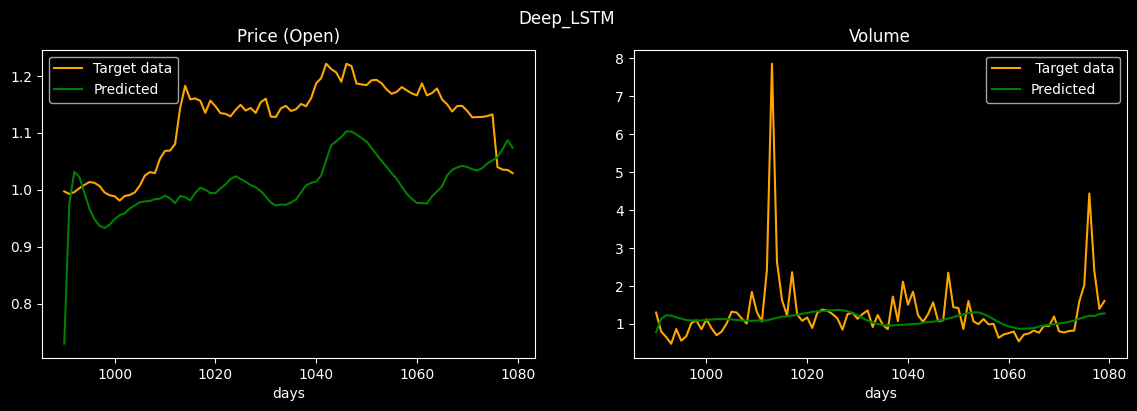

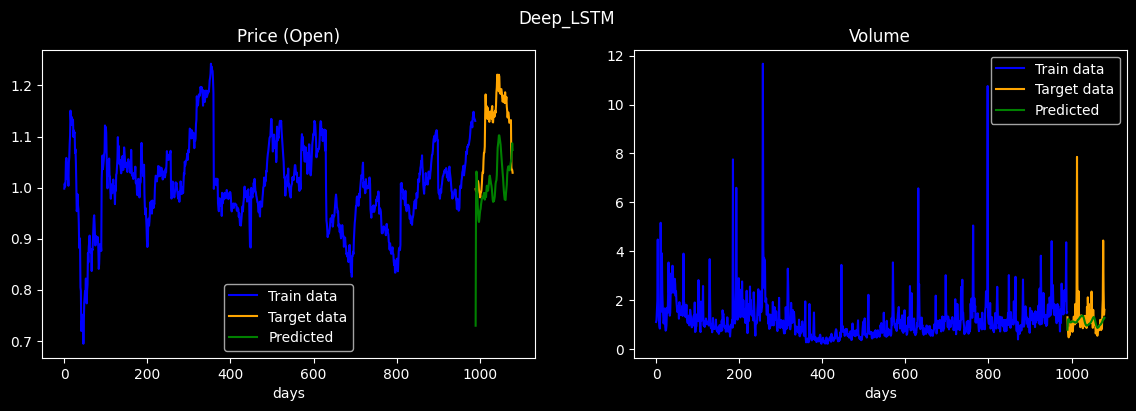

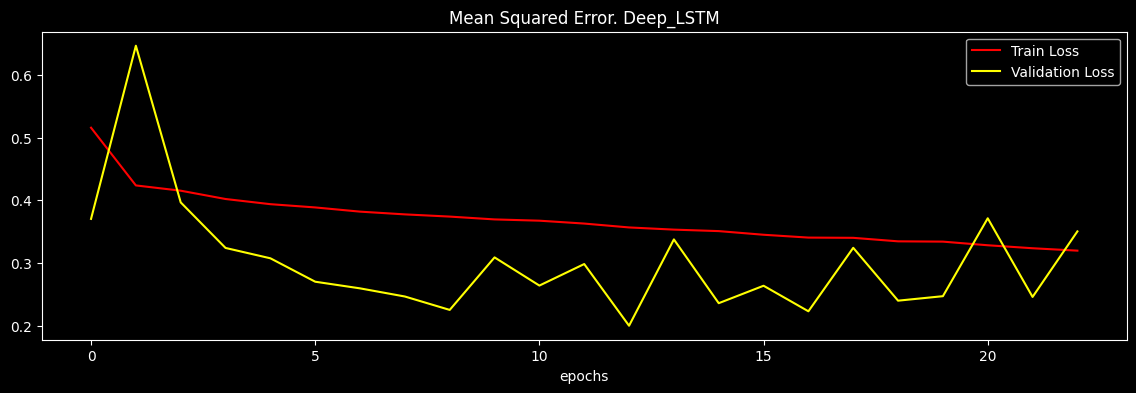

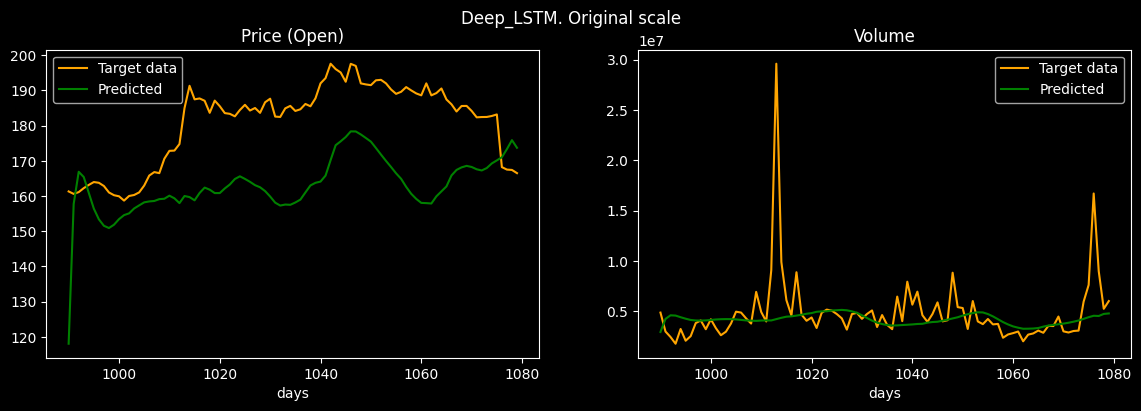

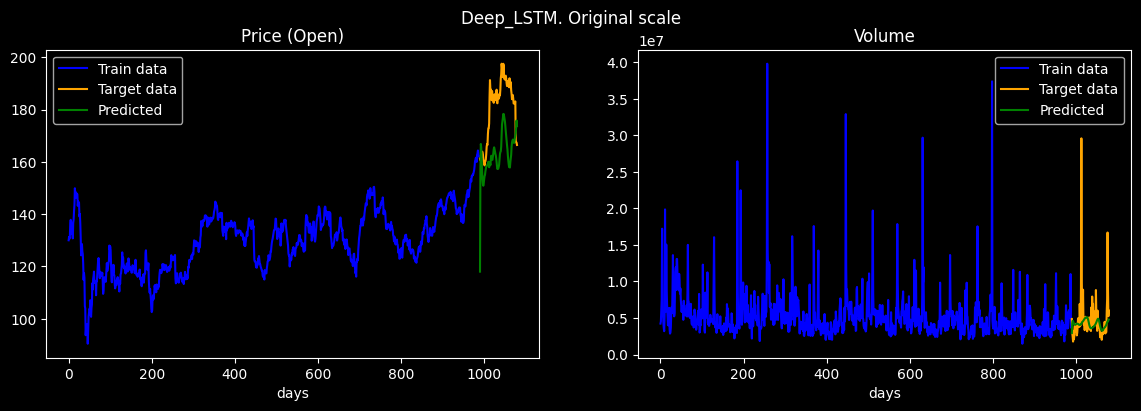

In [28]:
model_results(yhat_deep_lstm, history_deep_lstm, data=scaled_data, model_name=best_deep_lstm.name, scaler=scaler)
model_error_params(yhat_deep_lstm, best_deep_lstm, best_hps_deep_lstm, mse_models,length=length)

#### GRU (Gated Recurrent Units)

In [29]:
def build_gru(hp):
    model = keras.models.Sequential(name = 'GRU')
    model.add(keras.layers.Input(shape=(length, 2)))
    model.add(keras.layers.GRU(units=hp.Choice('units', [50, 75, 100, 125, 150]), return_sequences=True))
    model.add(keras.layers.Dropout(rate=hp.Choice('rate',[0.0, 0.1, 0.2, 0.3])))
    model.add(keras.layers.Dense(units=2))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1] )
    optimizers_dict = {
        'RMSprop': keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
        'Adam': keras.optimizers.Adam(learning_rate=hp_learning_rate)
    }
    hp_optimizers = hp.Choice('optimizer', values=['RMSprop', 'Adam'])
    model.compile(optimizer=optimizers_dict[hp_optimizers], loss='mse')
    return model

#build_gru(kt.HyperParameters())

tuner_gru = kt.RandomSearch(
    build_gru,
    objective='val_loss',
    max_trials = 50, 
    max_retries_per_trial=3,
    max_consecutive_failed_trials=5,
    overwrite=True,
    project_name='ibm-stock-gru')

tuner_gru.search_space_summary()

Search space summary
Default search space size: 4
units (Choice)
{'default': 50, 'conditions': [], 'values': [50, 75, 100, 125, 150], 'ordered': True}
rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}
optimizer (Choice)
{'default': 'RMSprop', 'conditions': [], 'values': ['RMSprop', 'Adam'], 'ordered': False}


In [30]:
tuner_gru.search(X_train[:-length], y_train[:-length], 
                 validation_data =(X_train[-length:], y_train[-length:]), 
                 epochs=50, 
                 callbacks=[early_stop])
tuner_gru.results_summary(num_trials=2)

Trial 50 Complete [00h 00m 20s]
val_loss: 0.17949095368385315

Best val_loss So Far: 0.14269541203975677
Total elapsed time: 00h 18m 56s
Results summary
Results in ./ibm-stock-gru
Showing 2 best trials
Objective(name="val_loss", direction="min")

Trial 34 summary
Hyperparameters:
units: 75
rate: 0.3
learning_rate: 0.001
optimizer: RMSprop
Score: 0.14269541203975677

Trial 46 summary
Hyperparameters:
units: 125
rate: 0.1
learning_rate: 0.001
optimizer: RMSprop
Score: 0.14365316927433014


In [31]:
best_hps_gru=tuner_gru.get_best_hyperparameters(num_trials=1)[0]
best_gru = build_gru(best_hps_gru)
best_gru.summary()

history_gru = best_gru.fit(X_train[:-1], y_train[:-1], 
                           validation_data =(X_train[-1:], y_train[-1:]), 
                           epochs=50,  
                           callbacks=[early_stop])
yhat_gru = best_gru.predict(X_test)

Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 90, 75)         │        17,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90, 2)          │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,927 (70.03 KB)

 Trainable params: 17,927 (70.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.0074 - val_loss: 0.4173
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.4271 - val_loss: 0.3590
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.4164 - val_loss: 0.2857
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.4058 - val_loss: 0.3934
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3937 - val_loss: 0.4027
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3953 - val_loss: 0.3518
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3943 - val_loss: 0.3169
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3925 - val_loss: 0.3863
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3929 - val_loss: 0.4080
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3970 - val_loss: 0.3316
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3978 - val_loss: 0.3781
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.3

MSE for the last 90 days predicted:  0.41568419949564644
Best hyperparameters found for model GRU: {'units': 75, 'rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}


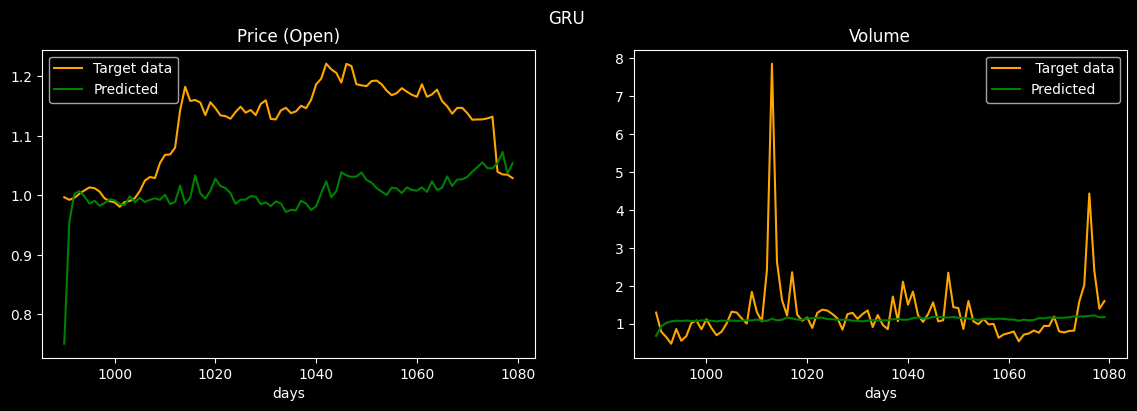

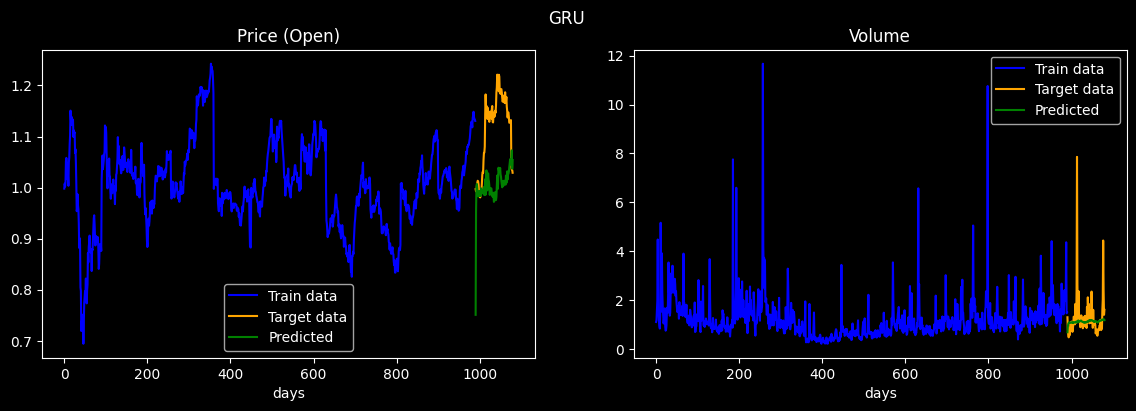

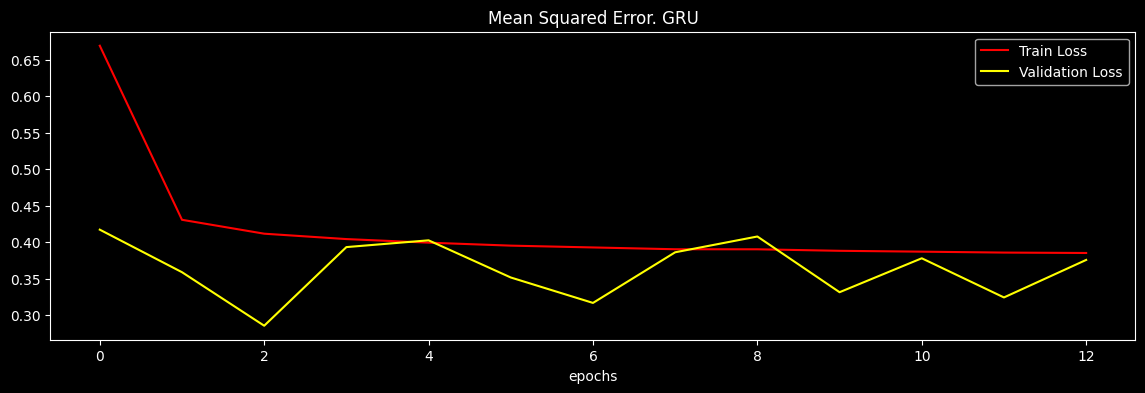

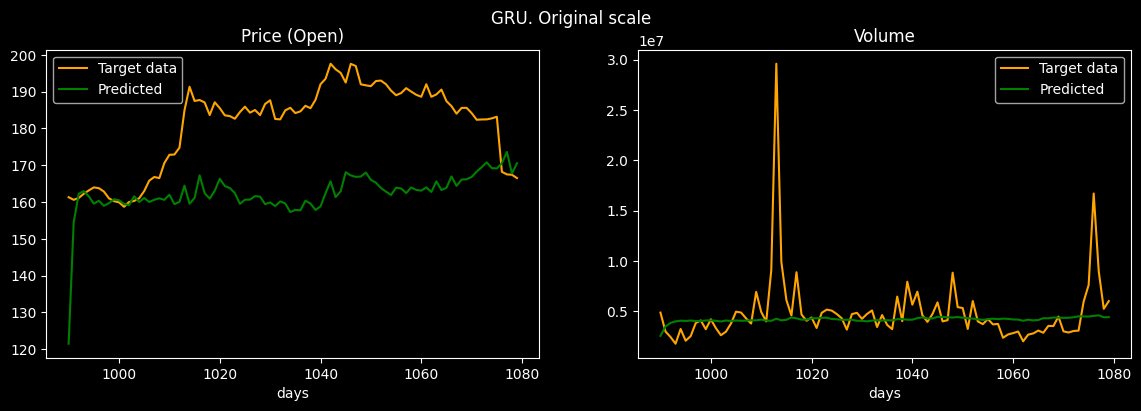

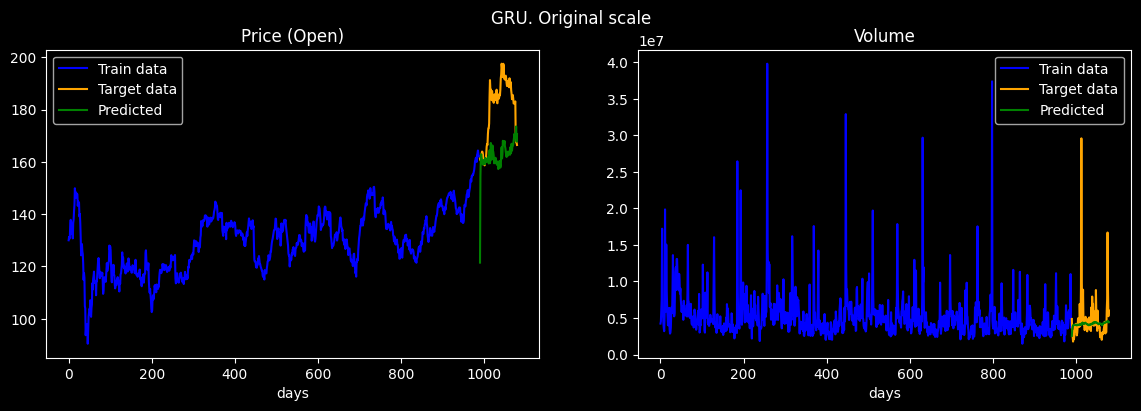

In [32]:
model_results(yhat_gru, history_gru, data= scaled_data, model_name=best_gru.name, scaler=scaler)
model_error_params(yhat_gru, best_gru, best_hps_gru, mse_models,length=length)

#### Deep GRU (two hidden layers)

In [33]:
def build_deep_gru(hp):
    model = keras.models.Sequential(name = 'Deep_GRU')
    model.add(keras.layers.Input(shape=(length, 2)))
    model.add(keras.layers.GRU(units=hp.Choice('units_1', [50, 75, 100, 125, 150]), return_sequences=True))
    #model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.GRU(units=hp.Choice('units_2', [50, 75, 100, 125, 150]), return_sequences=True))
    model.add(keras.layers.Dropout(rate=hp.Choice('rate',[0.0, 0.1, 0.2, 0.3])))
    model.add(keras.layers.Dense(units=2))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1] )
    optimizers_dict = {
        'RMSprop': keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
        'Adam': keras.optimizers.Adam(learning_rate=hp_learning_rate)
    }
    hp_optimizers = hp.Choice('optimizer', values=['RMSprop', 'Adam'])
    model.compile(optimizer=optimizers_dict[hp_optimizers], loss='mse')
    return model

#build_deep_gru(kt.HyperParameters())

tuner_deep_gru = kt.RandomSearch(
    build_deep_gru,
    objective='val_loss',
    max_trials = 50, 
    max_retries_per_trial=3,
    max_consecutive_failed_trials=5,
    overwrite=True,
    project_name='ibm-stock-deep-gru')

tuner_deep_gru.search_space_summary()

Search space summary
Default search space size: 5
units_1 (Choice)
{'default': 50, 'conditions': [], 'values': [50, 75, 100, 125, 150], 'ordered': True}
units_2 (Choice)
{'default': 50, 'conditions': [], 'values': [50, 75, 100, 125, 150], 'ordered': True}
rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1], 'ordered': True}
optimizer (Choice)
{'default': 'RMSprop', 'conditions': [], 'values': ['RMSprop', 'Adam'], 'ordered': False}


In [34]:
tuner_deep_gru.search(X_train[:-length], y_train[:-length], 
                      validation_data =(X_train[-length:], y_train[-length:]),
                      epochs=50, 
                      callbacks=[early_stop])
tuner_deep_gru.results_summary(num_trials=2)

Trial 50 Complete [00h 00m 26s]
val_loss: 0.17024460434913635

Best val_loss So Far: 0.14495685696601868
Total elapsed time: 00h 32m 48s
Results summary
Results in ./ibm-stock-deep-gru
Showing 2 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
units_1: 50
units_2: 150
rate: 0.1
learning_rate: 0.001
optimizer: Adam
Score: 0.14495685696601868

Trial 26 summary
Hyperparameters:
units_1: 125
units_2: 50
rate: 0.2
learning_rate: 0.001
optimizer: Adam
Score: 0.14664660394191742


In [35]:
best_hps_deep_gru=tuner_deep_gru.get_best_hyperparameters(num_trials=1)[0]
best_deep_gru = build_deep_gru(best_hps_deep_gru)
best_deep_gru.summary()

history_deep_gru = best_deep_gru.fit(X_train[:-1], y_train[:-1], 
                                     validation_data =(X_train[-1:], y_train[-1:]),
                                     epochs=50,  
                                     callbacks=[early_stop])
yhat_deep_gru = best_deep_gru.predict(X_test)

Model: "Deep_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 90, 50)         │         8,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 90, 150)        │        90,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90, 2)          │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,302 (387.90 KB)

 Trainable params: 99,302 (387.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.8233 - val_loss: 0.3590
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.4168 - val_loss: 0.3110
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.4163 - val_loss: 0.3487
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.3898 - val_loss: 0.3718
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.3804 - val_loss: 0.2902
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.3825 - val_loss: 0.3221
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.3789 - val_loss: 0.3390
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.3807 - val_loss: 0.3100
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.3729 - val_loss: 0.2560
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.3639 - val_loss: 0.2541
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.3662 - val_loss: 0.2460
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.3

MSE for the last 90 days predicted:  0.42289310914661954
Best hyperparameters found for model Deep_GRU: {'units_1': 50, 'units_2': 150, 'rate': 0.1, 'learning_rate': 0.001, 'optimizer': 'Adam'}


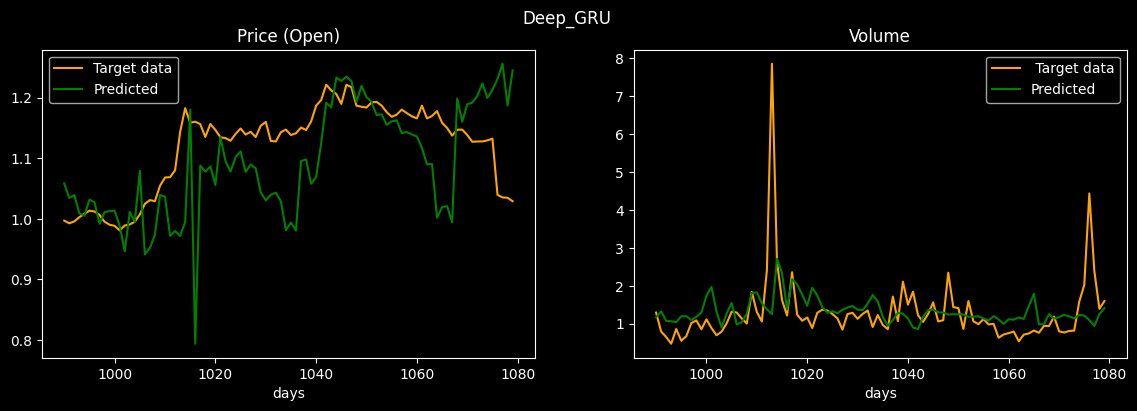

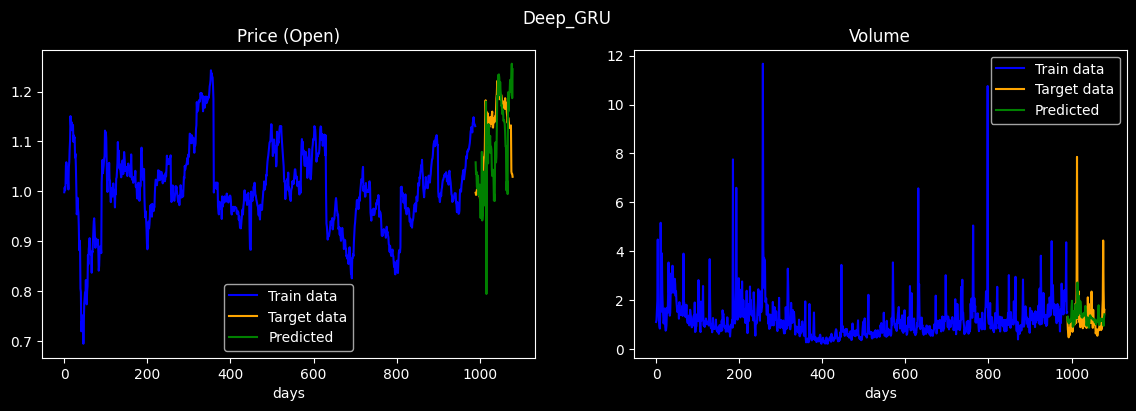

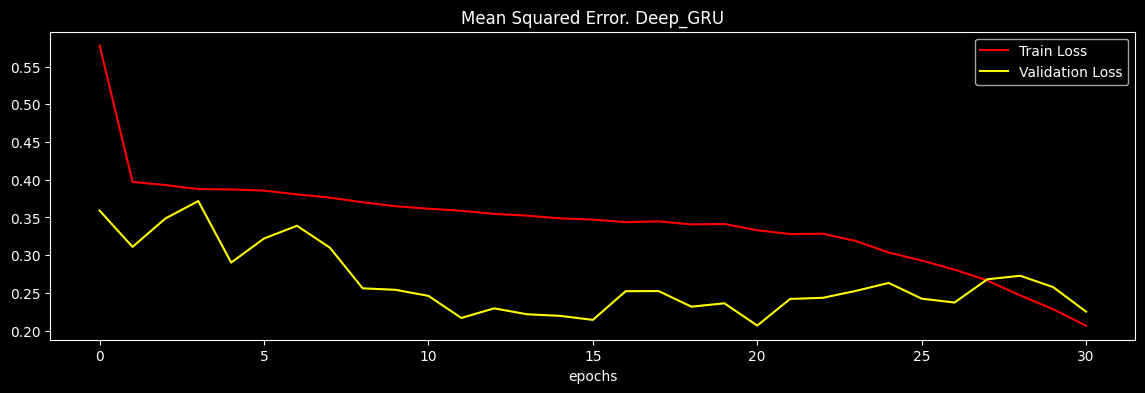

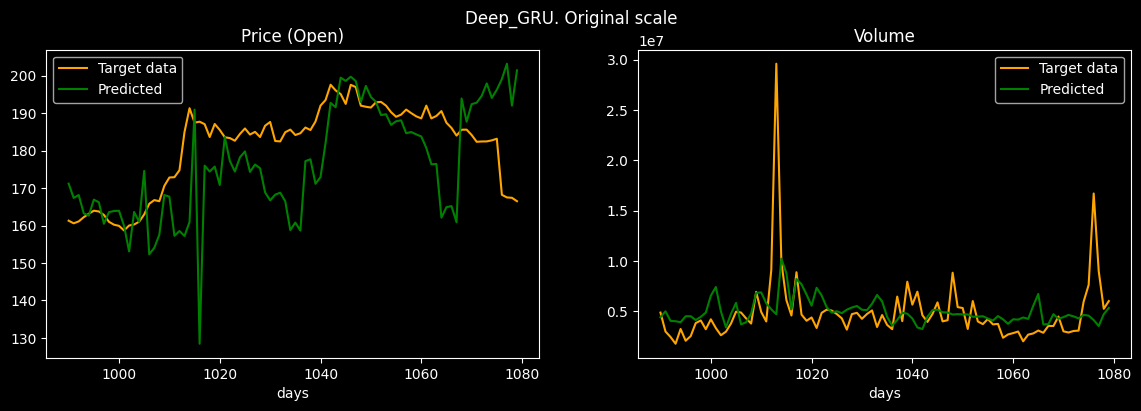

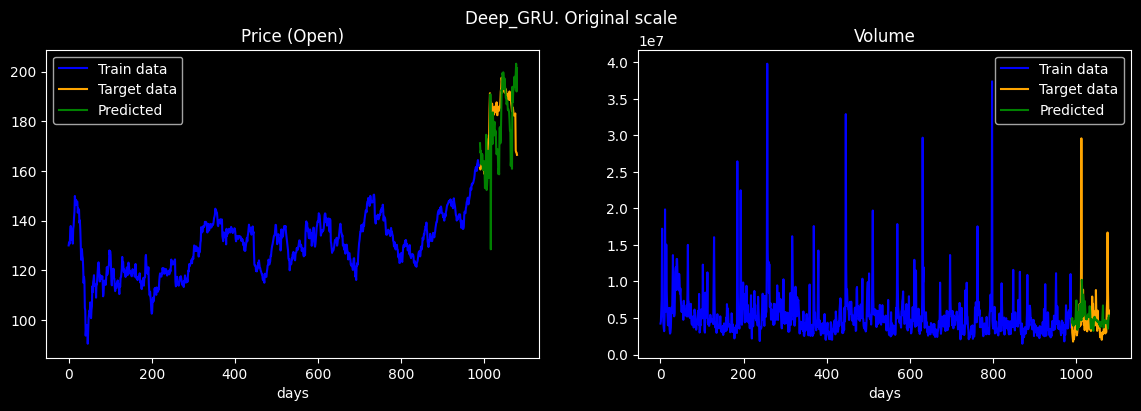

In [36]:
model_results(yhat_deep_gru, history_deep_gru, data=scaled_data, model_name=best_deep_gru.name, scaler=scaler)
model_error_params(yhat_deep_gru, best_deep_gru, best_hps_deep_gru, mse_models)

## 5.Summary of the results

Text(0, 0.5, 'MSE')

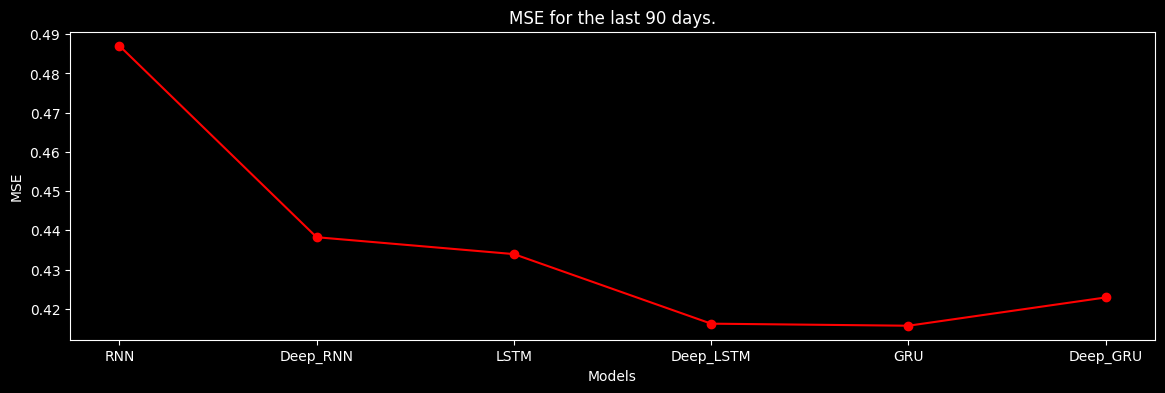

In [37]:
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1,1,1)
ax.plot(pd.Series(mse_models), color='red', marker ='o')
#ax.legend()
ax.set_title(f'MSE for the last {length} days.')
ax.set_xlabel('Models')
ax.set_ylabel('MSE')

#### Best Model Considered: Deep LSTM and GRU

##### Deep LSTM

MSE for the last 90 days predicted:  0.41620735890886734
Best hyperparameters found for model Deep_LSTM: {'units_1': 150, 'units_2': 75, 'rate': 0.2, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}


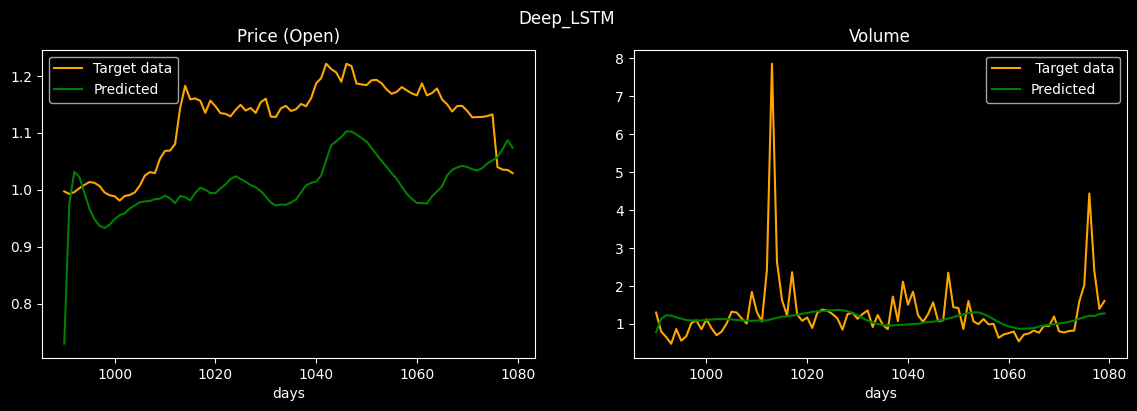

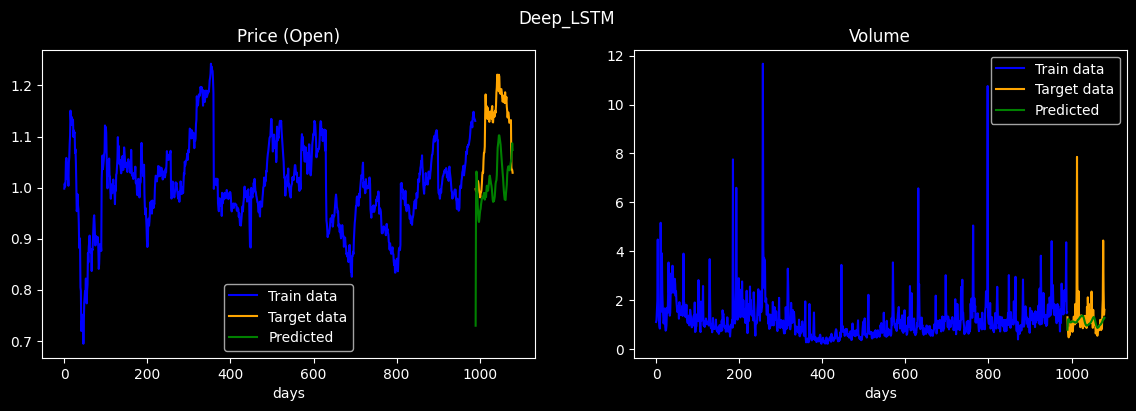

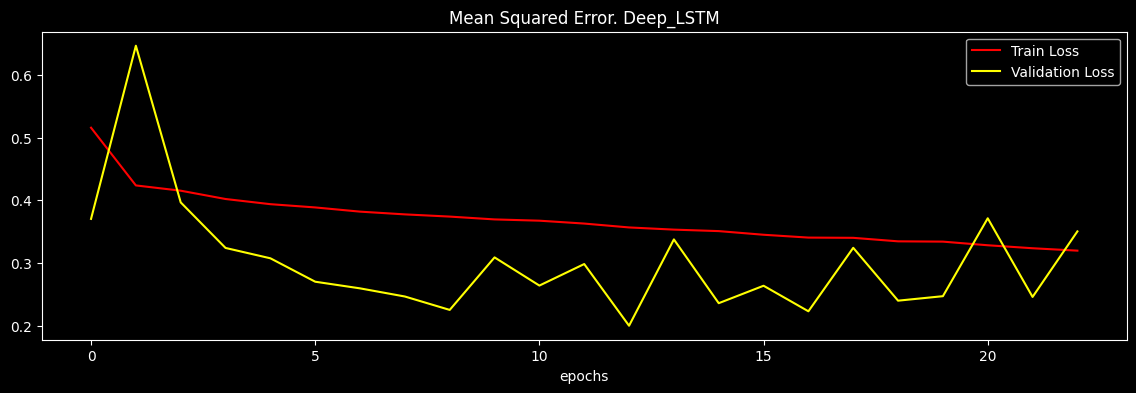

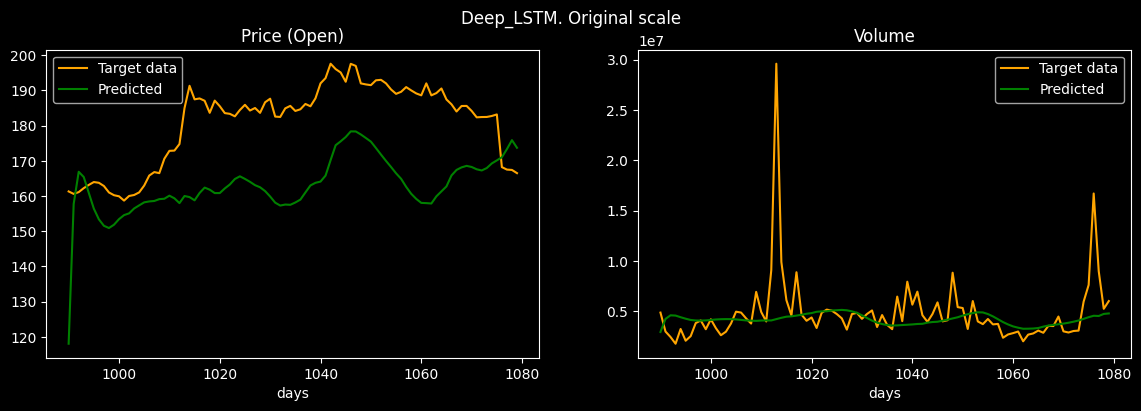

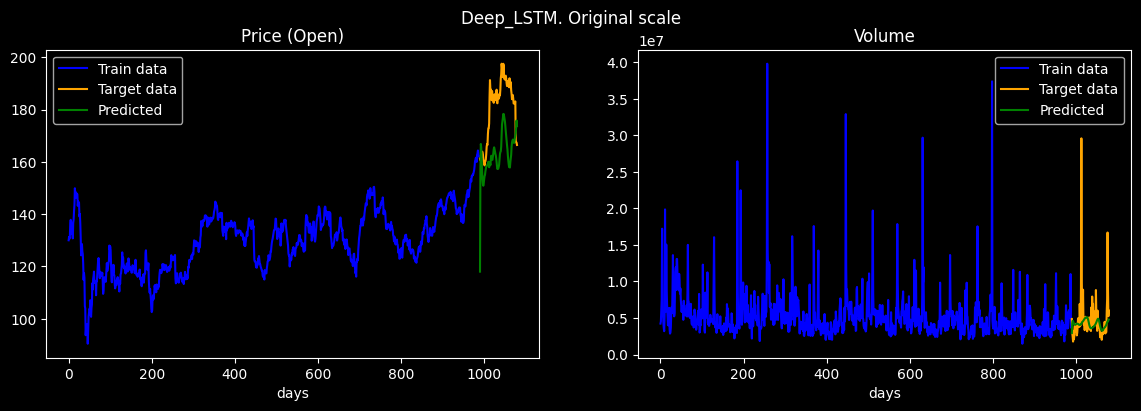

In [39]:
model_results(yhat_deep_lstm, history_deep_lstm, data=scaled_data,model_name=best_deep_lstm.name, scaler=scaler)
model_error_params(yhat_deep_lstm, best_deep_lstm, best_hps_deep_lstm, mse_models)

##### GRU

MSE for the last 90 days predicted:  0.41568419949564644
Best hyperparameters found for model GRU: {'units': 75, 'rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'RMSprop'}


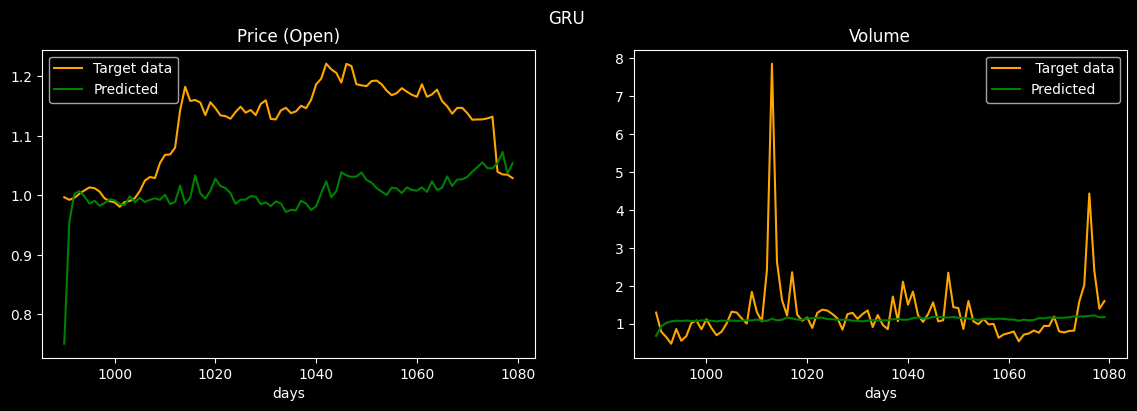

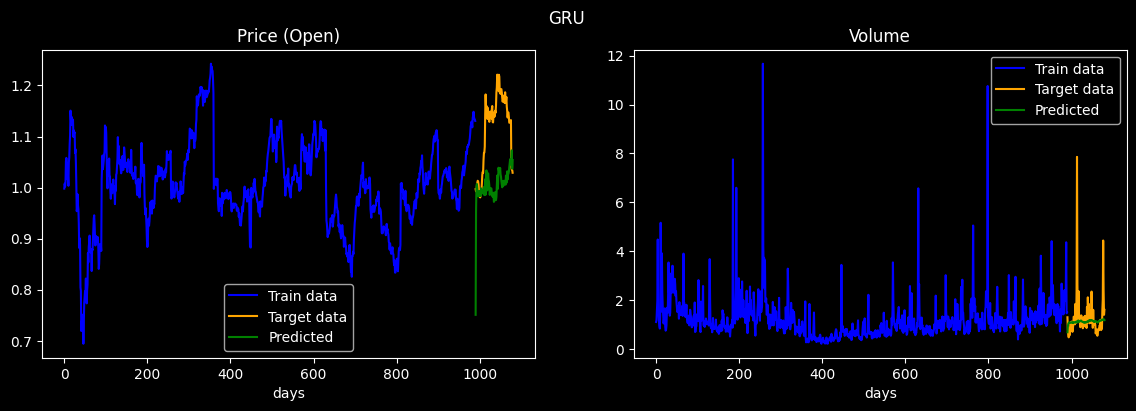

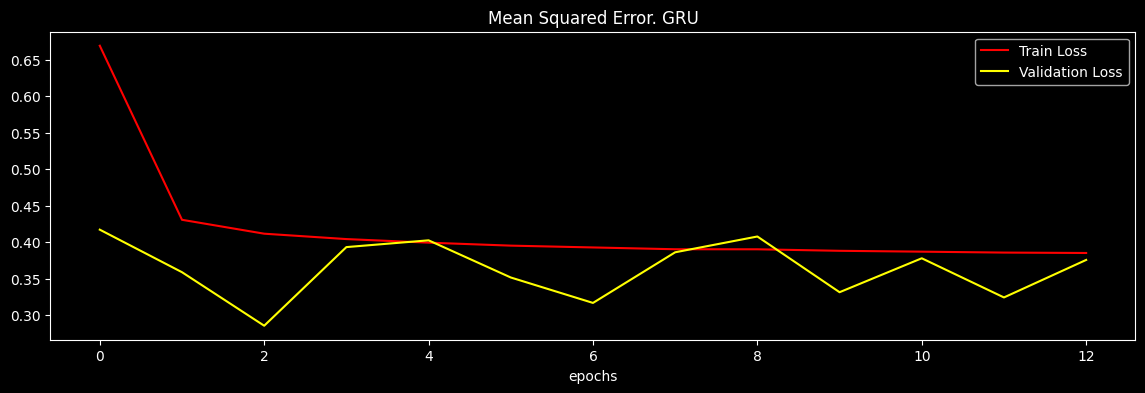

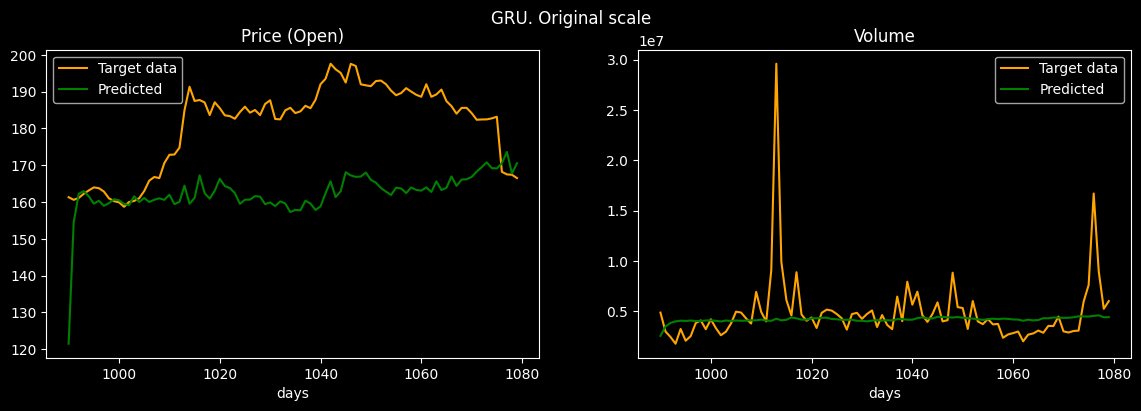

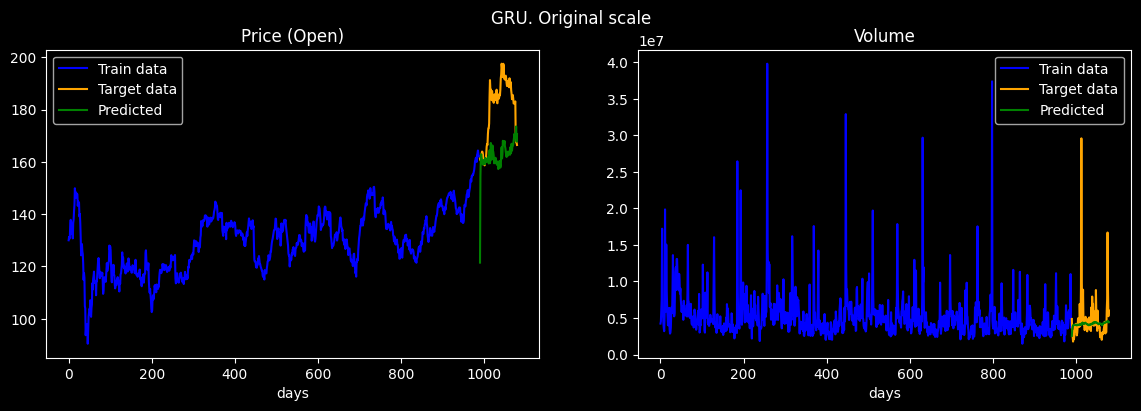

In [40]:
model_results(yhat_gru, history_gru, data=scaled_data,model_name=best_gru.name, scaler=scaler)
model_error_params(yhat_gru, best_gru, best_hps_gru, mse_models)

## 6.Conclusion

We considered a dataset containing stock Prices and Volumes for about 1000 days. We tuned hyperparameters (number of units, dropout rate, optimizer, learning_rate) and train some RNN models to predict the stock price/volume for the last 90 days of the dataset. After RandomSearch hyperparameter tuning, and using MSE as error metric, we found the Deep_LSTM (with two hidden layers) and the GRU models as the ones with the lowest error metric. 

The models considered were very simple and there could be many ways in which they can be improved. For example, using different scaling techniques, consider a custom metric for data series, consider data from other companies with the same characteristics, explore different model architectures, perform a thorough hyperparameter search. In general, predicting stock prices is not an easy task. 